## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from random import sample 
import scipy
import scipy.stats
from skimage import io

## General Overview

In [3]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
print(all_xray_df.shape)
all_xray_df.sample(3)

(112120, 12)


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
7799   00002048_016.png     No Finding           16        2048           44   
84795  00020894_000.png     No Finding            0       20894           49   
95376  00025076_000.png     No Finding            0       25076           65   

      Patient Gender View Position  OriginalImage[Width  Height]  \
7799               M            AP                 2500     2048   
84795              M            AP                 3056     2544   
95376              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
7799                         0.168  0.168          NaN  
84795                        0.139  0.139          NaN  
95376                        0.143  0.143          NaN

In [4]:
data_sample = pd.read_csv('sample_labels.csv')
print(data_sample.shape)
data_sample.sample(3)

(5606, 11)


Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
361   00001936_000.png     No Finding            0        1936        040Y   
782   00004090_002.png          Edema            2        4090        061Y   
5550  00030279_010.png   Pneumothorax           10       30279        072Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
361               M            PA                2500                 2048   
782               M            AP                2500                 2048   
5550              M            AP                3056                 2544   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
361                         0.171                        0.171  
782                         0.171                        0.171  
5550                        0.139                        0.139

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [5]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


Data set schemas appear similar same save 'Patient Age' type and extra column 'Unnamed: 11' in all_xray_df

## Full Dataset Summary

In [7]:
df_features = pd.DataFrame({'no missing': all_xray_df.isnull().sum(),
                            'percent missing': all_xray_df.isnull().sum()/len(all_xray_df),
                            'no unique': all_xray_df.nunique(),
                            'type': all_xray_df.dtypes}, 
                           index=all_xray_df.columns)
stats = all_xray_df.describe().T
df_features.join(stats)

no missing  percent missing  no unique     type  \
Image Index                           0              0.0     112120   object   
Finding Labels                        0              0.0        836   object   
Follow-up #                           0              0.0        184    int64   
Patient ID                            0              0.0      30805    int64   
Patient Age                           0              0.0        107    int64   
Patient Gender                        0              0.0          2   object   
View Position                         0              0.0          2   object   
OriginalImage[Width                   0              0.0        904    int64   
Height]                               0              0.0       1137    int64   
OriginalImagePixelSpacing[x           0              0.0         23  float64   
y]                                    0              0.0         23  float64   
Unnamed: 11                      112120              1.0          0  float64   

                                count          mean          std       min  \
Image Index                       NaN           NaN          NaN       NaN   
Finding Labels                    NaN           NaN          NaN       NaN   
Follow-up #                  112120.0      8.573751    15.406320     0.000   
Patient ID                   112120.0  14346.381743  8403.876972     1.000   
Patient Age                  112120.0     46.901463    16.839923     1.000   
Patient Gender                    NaN           NaN          NaN       NaN   
View Position                     NaN           NaN          NaN       NaN   
OriginalImage[Width          112120.0   2646.078844   341.246429  1143.000   
Height]                      112120.0   2486.438842   401.268227   966.000   
OriginalImagePixelSpacing[x  112120.0      0.155649     0.016174     0.115   
y]                           112120.0      0.155649     0.016174     0.115   
Unnamed: 11                       0.0           NaN          NaN       NaN   

                                  25%        50%        75%         max  
Image Index                       NaN        NaN        NaN         NaN  
Finding Labels                    NaN        NaN        NaN         NaN  
Follow-up #                     0.000      3.000     10.000    183.0000  
Patient ID                   7310.750  13993.000  20673.000  30805.0000  
Patient Age                    35.000     49.000     59.000    414.0000  
Patient Gender                    NaN        NaN        NaN         NaN  
View Position                     NaN        NaN        NaN         NaN  
OriginalImage[Width          2500.000   2518.000   2992.000   3827.0000  
Height]                      2048.000   2544.000   2991.000   4715.0000  
OriginalImagePixelSpacing[x     0.143      0.143      0.168      0.1988  
y]                              0.143      0.143      0.168      0.1988  
Unnamed: 11                       NaN        NaN        NaN         NaN

Dataset is clean in that there is no missing data.  

- Finding Labels: There are 836 combinations of labels, while there are only 14 disease class labels and a 'No - Findings' class for a total of 15 disease classes according the the literature (README_CHESTXRAY.pdf included with the dataset from Kaggle).  These disease class labels are: Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural_thickening, Cardiomegaly, Nodule, Mass and Hernia.

- Follow-up #: Looks like max follow-up may be erroneous (outlier vis a vis the rest of the data)
- Patient ID:  We have 30,805 patients, so it looks like we may have an average of about 3-4 images per patient.
- Patient Age: Max age is erroneous, needs some attention.  Should check the distribution.
- Gender: Should be investigated for balance.
- View Position: Should be investigated for balance.
- OriginalImage cols: variation in size, not square
- OriginalImagePixelSpacing cols: x and y are same despite variation range, simply showing square pixels
- Unnamed: 11 - to drop 

In [8]:
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)

In [9]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

Let's investigate various features of the dataset, starting with cleaning up suspected outliers.

### Patient Age

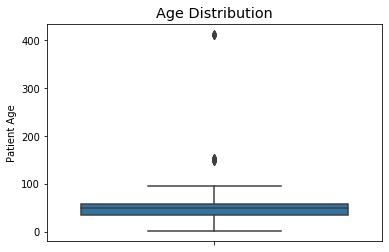

In [10]:
sns.boxplot(y=all_xray_df['Patient Age'])
plt.style.use('bmh')
plt.title('Age Distribution');

In [11]:
age_over_100 = all_xray_df['Patient Age']>100
print(len(all_xray_df[age_over_100]))
all_xray_df[age_over_100]

16


Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  
20852      2544                        0.139  0.139  
46965      2544                        0.139  0.139  
48284      2991                        0.143  0.143  
55742      2939                        0.143  0.143  
58650      2991                        0.143  0.143  
62929      2991                        0.143  0.143  
74884      2991                        0.143  0.143  
78795      2774                        0.143  0.143  
84810      2544                        0.139  0.139  
85404      2544                        0.139  0.139  
86264      2544                        0.139  0.139  
91369      2544                        0.139  0.139  
95794      2991                        0.143  0.143  
98495      2991                        0.143  0.143  
101194     2991                        0.143  0.143  
104590     2991                        0.143  0.143

Clearly, Patient Age data over 100 is erroneous as table above shows those values from 148 to 414.
We will remove these rows over age 100 and then check data mean and median to impute new values.

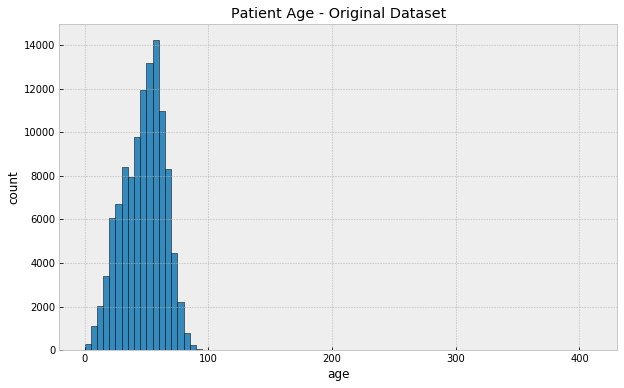

In [12]:
## EDA
plt.figure(figsize=(10,6))
plt.style.use('bmh')
plt.hist(all_xray_df['Patient Age'], bins=np.arange(0,np.max(all_xray_df['Patient Age']),5), ec="k");
plt.xlabel('age')
plt.ylabel('count')
plt.title('Patient Age - Original Dataset');

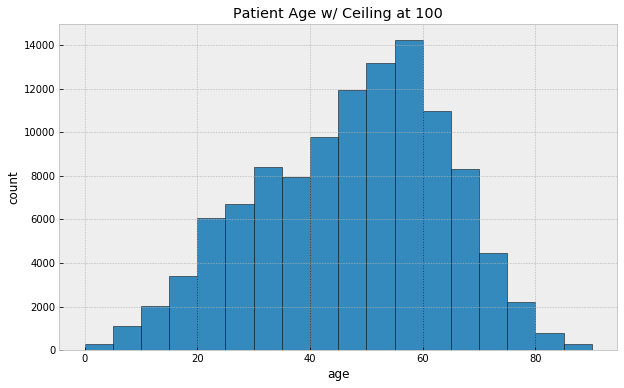

In [13]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[~age_over_100]['Patient Age'], bins=np.arange(0,np.max(all_xray_df[~age_over_100]['Patient Age']),5), ec="k");
plt.xlabel('age')
plt.ylabel('count')
plt.title('Patient Age w/ Ceiling at 100');

In [14]:
print('Mean Age: ', all_xray_df[~age_over_100]['Patient Age'].mean())
print('Median Age: ', all_xray_df[~age_over_100]['Patient Age'].median())
print(len(all_xray_df[~age_over_100]))

Mean Age:  46.872573681581386
Median Age:  49.0
112104


Data is slightly skewed left so will replace erroneous age values w/ the median

Mean:  46.87287727434891 , Median:  49.0
112120


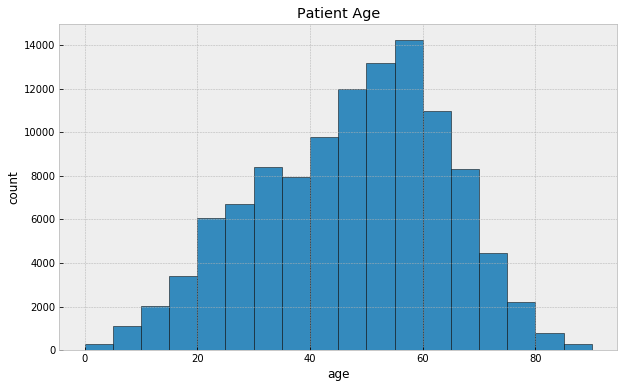

In [15]:
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].apply(lambda x:  all_xray_df[~age_over_100]['Patient Age'].median() if x > 100 else x)
plt.figure(figsize=(10,6))

plt.hist(all_xray_df['Patient Age'], bins=np.arange(0,np.max(all_xray_df['Patient Age']),5), ec="k");
plt.xlabel('age')
plt.ylabel('count')
plt.title('Patient Age');
print('Mean: ', all_xray_df['Patient Age'].mean(), ', Median: ', all_xray_df['Patient Age'].median())
print(len(all_xray_df))

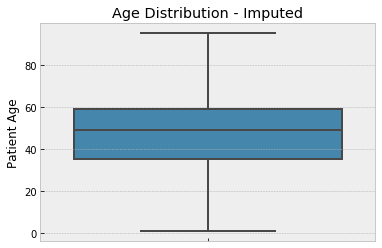

In [16]:
sns.boxplot(y=all_xray_df['Patient Age'])
plt.style.use('bmh')
plt.title('Age Distribution - Imputed');

In [17]:
age_df = all_xray_df.copy()
age_bins = np.arange(0, 100, 10)
a_bin = [str(x) for x in np.arange(0, 100, 10) ]
age_labels = ["".join(x) for x in zip( [x + " - " for x in a_bin[:-1]], a_bin[1:])]
age_df['age_bins'] = pd.cut(age_df['Patient Age'], bins=age_bins, labels=age_labels)

In [18]:
age_df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0              58.0              M            PA                 2682   
1              58.0              M            PA                 2894   
2              58.0              M            PA                 2500   
3              81.0              M            PA                 2500   
4              81.0              F            PA                 2582   
...             ...            ...           ...                  ...   
112115         39.0              M            PA                 2048   
112116         29.0              M            PA                 2048   
112117         42.0              F            PA                 2048   
112118         30.0              F            PA                 2048   
112119         27.0              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y] age_bins  
0          2749                        0.143  0.143  50 - 60  
1          2729                        0.143  0.143  50 - 60  
2          2048                        0.168  0.168  50 - 60  
3          2048                        0.171  0.171  80 - 90  
4          2991                        0.143  0.143  80 - 90  
...         ...                          ...    ...      ...  
112115     2500                        0.168  0.168  30 - 40  
112116     2500                        0.168  0.168  20 - 30  
112117     2500                        0.168  0.168  40 - 50  
112118     2500                        0.168  0.168  20 - 30  
112119     2500                        0.171  0.171  20 - 30  

[112120 rows x 12 columns]

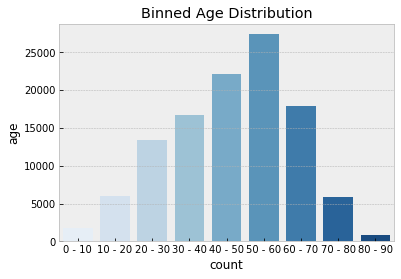

In [19]:
ax = sns.countplot(x="age_bins", data=age_df, palette='Blues')
ax.set(xlabel='count', ylabel='age')
plt.title('Binned Age Distribution');

Normal distribution below 100

### Follow Up 

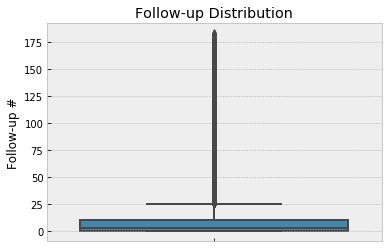

In [20]:
sns.boxplot(y=all_xray_df['Follow-up #'])
plt.style.use('bmh')
plt.title('Follow-up Distribution');

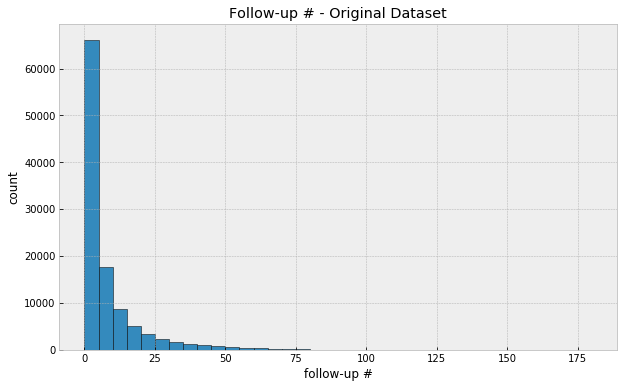

In [21]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Follow-up #'], bins=np.arange(0,np.max(all_xray_df['Follow-up #']),5), ec="k");
plt.xlabel('follow-up #')
plt.ylabel('count')
plt.title('Follow-up # - Original Dataset');

It appears that majority of patients have a relatively low follow-up #, given the range.

In [22]:
all_xray_df['Follow-up #'].describe()

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

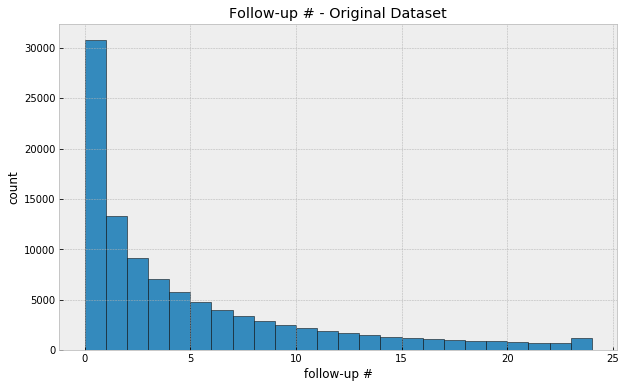

In [23]:
# Zoom in
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Follow-up #'], bins=np.arange(0,25,1), ec="k");
plt.xlabel('follow-up #')
plt.ylabel('count')
plt.title('Follow-up # - Original Dataset');

In [24]:
# let's use pandas qcut (quantile cut - quantile-based discretization function) 
# to see what distribution ranges would be for chosen 10 relatively equal size bins

followup_discretised, intervals = pd.qcut(
    all_xray_df['Follow-up #'], 10, labels=None, retbins=True, precision=3, duplicates='drop')

follow_freq = pd.concat([followup_discretised, all_xray_df['Follow-up #']], axis=1)
follow_freq.columns = ['Range','Follow-up #']
print(follow_freq.shape)
follow_freq.sample(3)

(112120, 2)


Range  Follow-up #
80141  (-0.001, 1.0]            0
1814   (24.0, 183.0]           49
40326     (3.0, 5.0]            5

In [25]:
intervals

array([  0.,   1.,   2.,   3.,   5.,   8.,  12.,  24., 183.])

In [26]:
followup_discretised.value_counts()

(-0.001, 1.0]    44107
(12.0, 24.0]     11608
(24.0, 183.0]    10732
(3.0, 5.0]       10580
(5.0, 8.0]       10392
(1.0, 2.0]        9189
(8.0, 12.0]       8423
(2.0, 3.0]        7089
Name: Follow-up #, dtype: int64

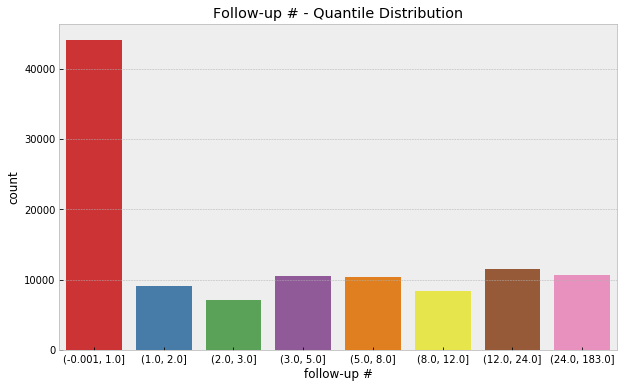

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(x='Range', data=follow_freq, palette='Set1')
plt.xlabel('follow-up #')
plt.ylabel('count')
plt.title('Follow-up # - Quantile Distribution');

In [28]:
# clearly most 1 or below, how many are 0 (no follow-ups) vs 1 follow-up
len(all_xray_df[all_xray_df['Follow-up #']==0]), len(all_xray_df[all_xray_df['Follow-up #']==1])

(30805, 13302)

In [29]:
# what percentage have very high number follow-ups (largest range of 24-183)?
len(all_xray_df[all_xray_df['Follow-up #']>24])/len(all_xray_df)

0.09571887263646094

Looking above at the distribution and values of 0 and 1 specifically, we can see that most people have no follow-up (0 = 30,805), then (1=13,302) and then we have shown relatively equal quantiles moving up from there, with about 9.57% having more than 24 follow-ups.

### Patient Gender

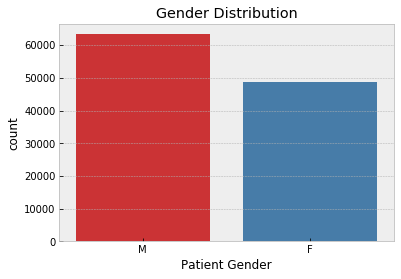

In [30]:
sns.countplot(all_xray_df['Patient Gender'], palette="Set1");
plt.title('Gender Distribution');

In [31]:
def show_proportions(df, col):
    print(f'{col} Counts:')
    print(df[col].value_counts(),'\n')
    print('Percentages:')
    print(df[col].value_counts(normalize=True) * 100, '\n')

In [32]:
show_proportions(all_xray_df, 'Patient Gender')

Patient Gender Counts:
M    63340
F    48780
Name: Patient Gender, dtype: int64 

Percentages:
M    56.493043
F    43.506957
Name: Patient Gender, dtype: float64 



### X-ray View Position

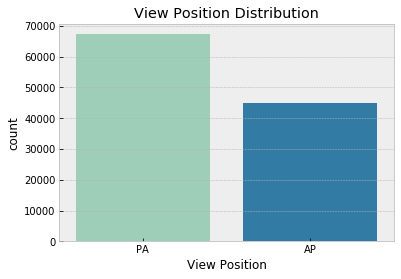

In [33]:
sns.countplot(all_xray_df['View Position'], palette="YlGnBu");
plt.title('View Position Distribution');

In [34]:
show_proportions(all_xray_df, 'View Position')

View Position Counts:
PA    67310
AP    44810
Name: View Position, dtype: int64 

Percentages:
PA    60.033892
AP    39.966108
Name: View Position, dtype: float64 



### Patient Gender and Age, Patient Age and View Position, Patient Gender and View Position

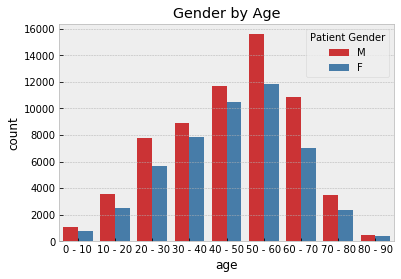

In [35]:
ax = sns.countplot(x="age_bins", hue="Patient Gender", data=age_df, palette="Set1");
ax.set(xlabel='age', ylabel='count')
plt.title('Gender by Age');

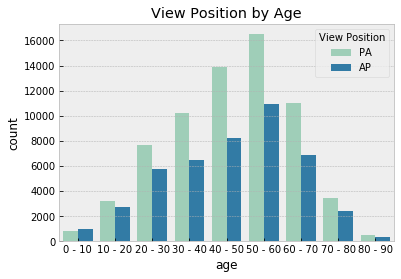

In [36]:
ax = sns.countplot(x="age_bins", hue="View Position", data=age_df, palette='YlGnBu');
ax.set(xlabel='age', ylabel='count')
plt.title('View Position by Age');

PA (Posterior-Anterior) is skewed left, and AP (Anterior-Posterior) is skewed right.  Both sort of normal.  More equal at extremes (<20, >70).

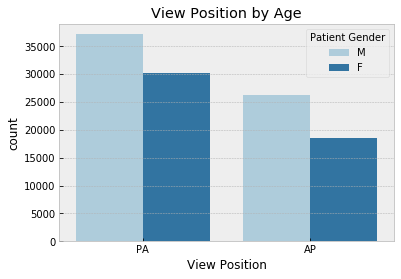

In [37]:
sns.countplot(all_xray_df['View Position'], hue=all_xray_df['Patient Gender'], palette='Paired');
plt.title('View Position by Age');

Positioning similar across gender.

## Findings

### Label Preprocessing and Binary Disease Columns 

In [38]:
# Process findings and compare with literature description 
# from README_CHESTXRAY.pdf (included with NIH Dataset):
lit_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 
              'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('Dataset distinct labels: \n', labels)

label_diff = list(set(labels) - set(lit_labels))
print('\nLabel difference: \n', label_diff)

Dataset distinct labels: 
 ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']

Label difference: 
 ['Pleural_Thickening', 'No Finding']


Labels are consistent w/ literature description save casing and addition of 'No Finding' category.  

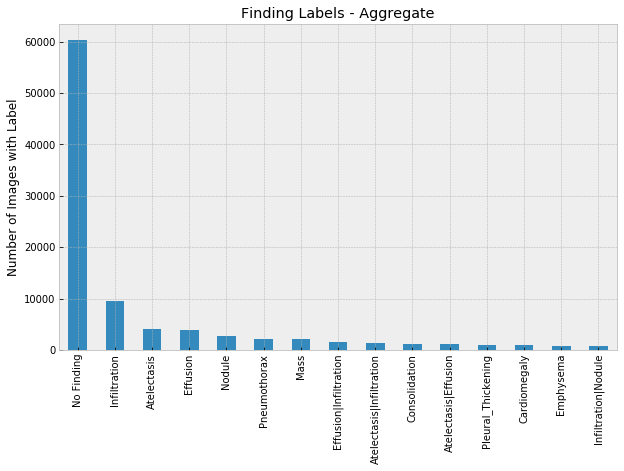

In [39]:
plt.figure(figsize=(10,6))
ax = all_xray_df['Finding Labels'].value_counts()[:15].sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
ax.set(title = 'Finding Labels - Aggregate');

We will create binary columns per disease to more easily process disease states.

In [40]:
df = all_xray_df.copy()
for disease in labels:
    df[disease] = df['Finding Labels'].map(lambda x: 1.0 if disease in x else 0)
print(df.shape)
df.sample(5)

(112120, 26)


Image Index            Finding Labels  Follow-up #  Patient ID  \
70122  00017261_000.png  Atelectasis|Infiltration            0       17261   
53831  00013594_012.png                     Edema           12       13594   
81009  00019898_000.png                No Finding            0       19898   
37007  00009740_000.png                No Finding            0        9740   
49661  00012610_001.png                No Finding            1       12610   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
70122         35.0              M            PA                 3056     2544   
53831         46.0              M            AP                 2500     2048   
81009         61.0              M            PA                 2992     2991   
37007         48.0              F            PA                 2500     2048   
49661         27.0              F            PA                 2426     2493   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
70122                        0.139  ...        0.0       0.0     0.0   
53831                        0.168  ...        0.0       0.0     0.0   
81009                        0.143  ...        0.0       0.0     0.0   
37007                        0.168  ...        0.0       0.0     0.0   
49661                        0.143  ...        0.0       0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
70122           1.0   0.0         0.0     0.0                 0.0        0.0   
53831           0.0   0.0         0.0     0.0                 0.0        0.0   
81009           0.0   0.0         1.0     0.0                 0.0        0.0   
37007           0.0   0.0         1.0     0.0                 0.0        0.0   
49661           0.0   0.0         1.0     0.0                 0.0        0.0   

       Pneumothorax  
70122           0.0  
53831           0.0  
81009           0.0  
37007           0.0  
49661           0.0  

[5 rows x 26 columns]

In [41]:
print(df.shape)
df.columns

(112120, 26)


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

Look at distribution of unique diseases (todo: combine below into single table)

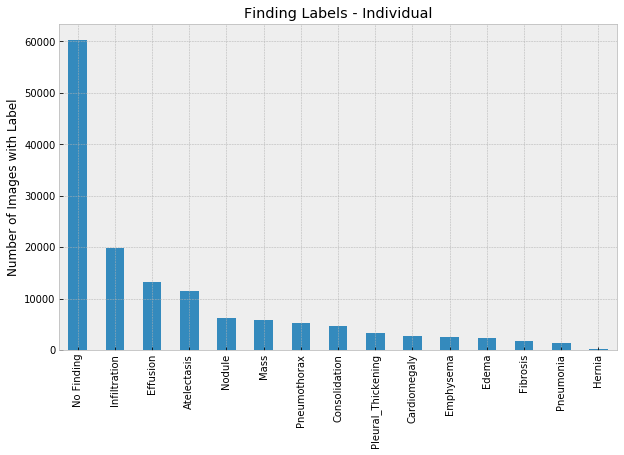

In [42]:
plt.figure(figsize=(10,6))
ax = df[labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
ax.set(title = 'Finding Labels - Individual');

In [43]:
# Totals
df[labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [44]:
# Percentages
(df[labels].sum()/len(df))*100

Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64

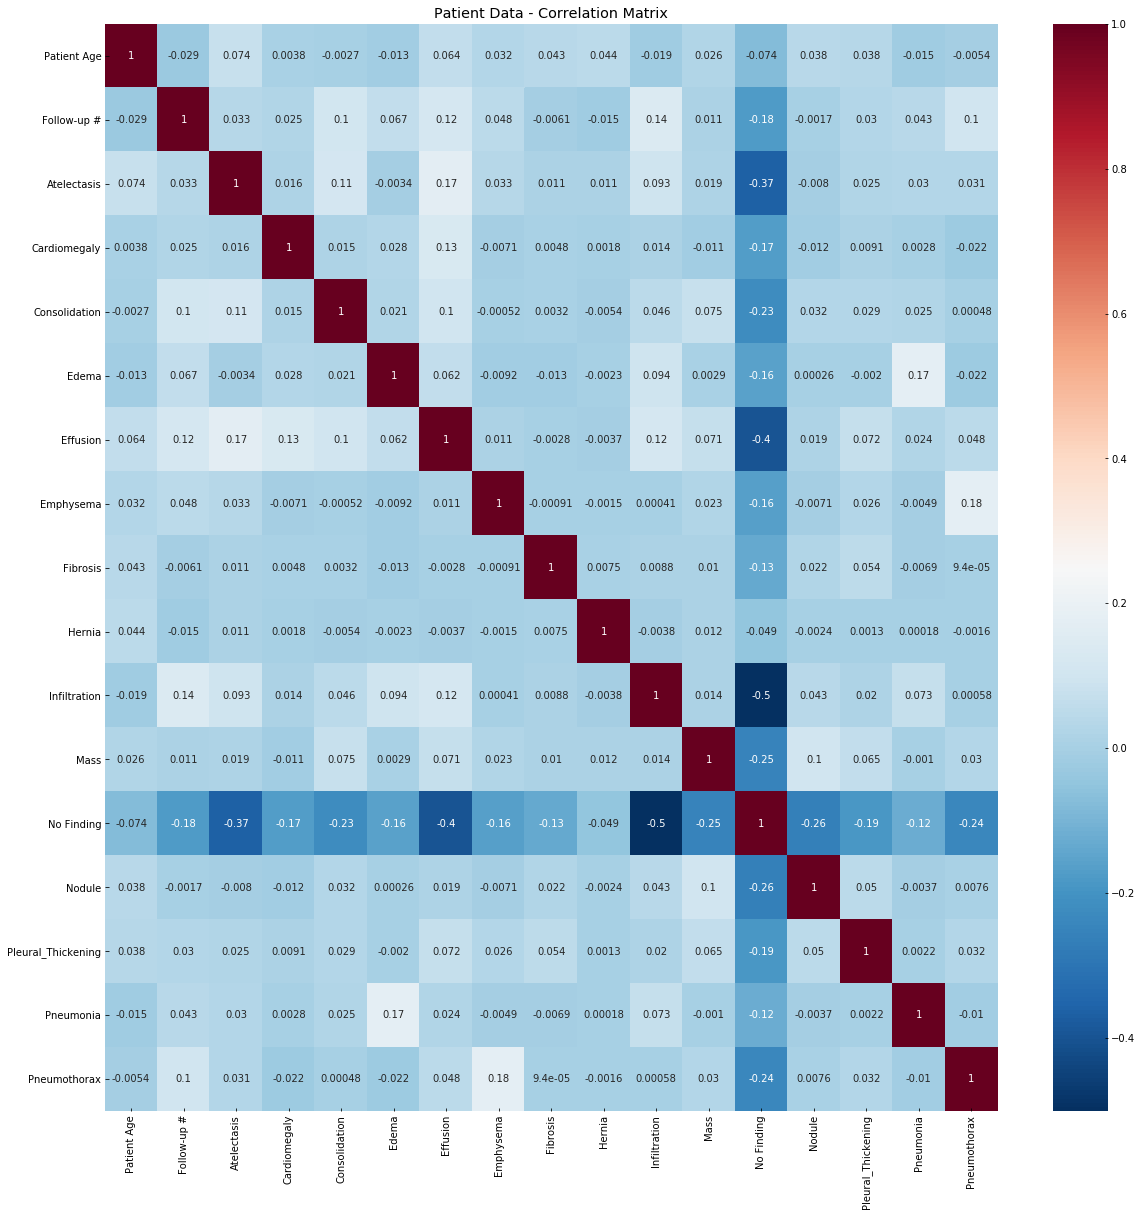

In [45]:
# Correlation Matrix
plt.figure(figsize=(20,20))

corrMatrix = df[np.append(['Patient Age', 'Follow-up #'], labels)].corr()
#sns.heatmap(corrMatrix, annot=True,cmap="YlGnBu")
sns.heatmap(corrMatrix, annot=True,cmap="RdBu_r")
plt.title('Patient Data - Correlation Matrix')
plt.show()

## Pneumonia

We are interested in particular in Pneumonia.  As we can see above in the chart and co-matrix, Pneumonia is relatively rare of described diseases.  Also co-occurence may be strong with edema and infiltration.

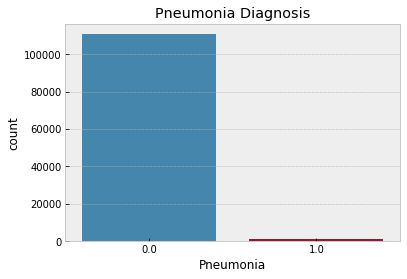

In [46]:
sns.countplot(x='Pneumonia', data=df)
plt.title('Pneumonia Diagnosis');

In [47]:
show_proportions(df, 'Pneumonia')

Pneumonia Counts:
0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64 

Percentages:
0.0    98.723689
1.0     1.276311
Name: Pneumonia, dtype: float64 



#### Disease Co-occurence

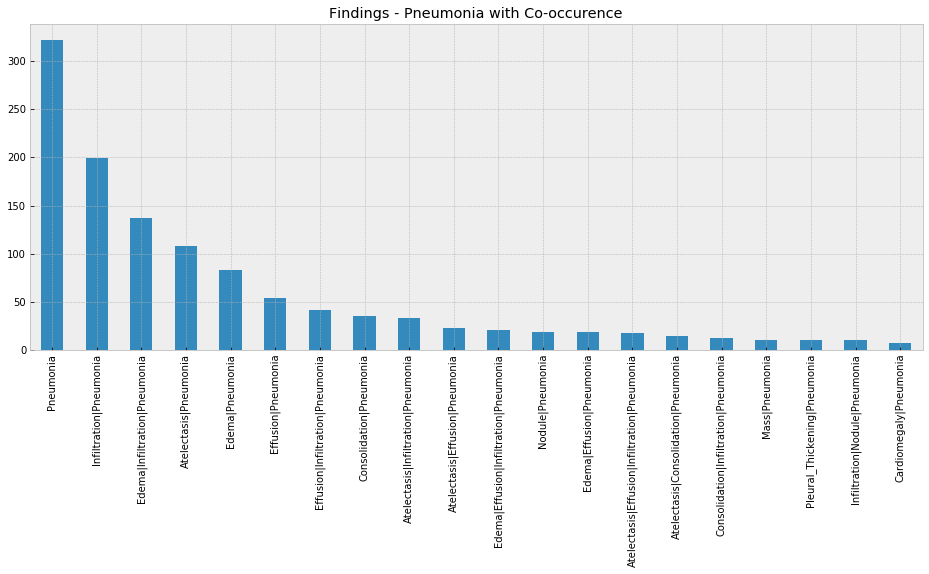

In [48]:
# Disease Co-occurrence
# Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[:20].plot(kind='bar')
plt.title('Findings - Pneumonia with Co-occurence');

Pneumonia is relatively rare in the sample, showing up only in  ~ 1.28% of the cases.  When seen, it is most often seen as a solitary diagnosis, followed up mostly by co-occurence w/ some combination of Infiltration, Edema, Alectasis, Effusion, and Consolidation,

#### Categorical Features: Gender and View Position

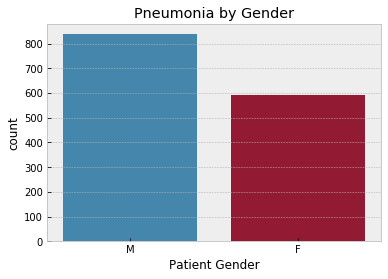

In [49]:
sns.countplot(df[df.Pneumonia==1]['Patient Gender'])
plt.title('Pneumonia by Gender');

In [50]:
show_proportions(df[df.Pneumonia==1], 'Patient Gender')

Patient Gender Counts:
M    838
F    593
Name: Patient Gender, dtype: int64 

Percentages:
M    58.560447
F    41.439553
Name: Patient Gender, dtype: float64 



We have a slightly disproportionate pneumonia distribution amongst gender, slightly higher for males, lower for females compared to gender distribution at large shown above.


Pneumonia  Patient Gender
0.0        F                 48187.0
           M                 62502.0
1.0        F                   593.0
           M                   838.0
Name: count, dtype: float64

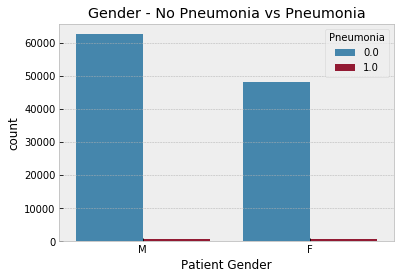

In [51]:
ax = sns.countplot(df['Patient Gender'], hue=df['Pneumonia']);
ax.set(title = 'Gender - No Pneumonia vs Pneumonia');
df.groupby(['Pneumonia', 'Patient Gender'])['Pneumonia'].describe()['count']

Pneumonia  View Position
0.0        AP               44009.0
           PA               66680.0
1.0        AP                 801.0
           PA                 630.0
Name: count, dtype: float64

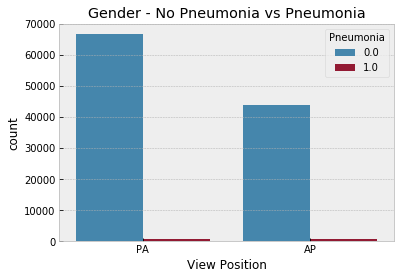

In [52]:
ax = sns.countplot(df['View Position'], hue=df['Pneumonia']);
ax.set(title = 'Gender - No Pneumonia vs Pneumonia');
df.groupby(['Pneumonia', 'View Position'])['Pneumonia'].describe()['count']

Pneumonia patients are disproportionately viewed in the AP (Anterior-Posterior) position, that position being less common at large than the PA (Posterior-Anterior) position.  The PA position is predominant throughout the age population as well except for the very young and the very old.

#### Numeric Features:  Follow-up # and Age

count       mean        std  min  25%  50%   75%    max
Pneumonia                                                            
0.0        110689.0   8.498053  15.322137  0.0  0.0  3.0   9.0  183.0
1.0          1431.0  14.429071  20.074835  0.0  2.0  7.0  18.0  155.0

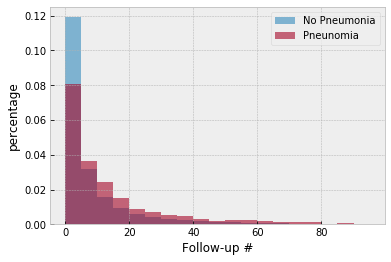

In [53]:
df.groupby(['Pneumonia'])['Follow-up #'].hist(bins=np.arange(0,100,5), density=True, alpha=0.6)
plt.legend(['No Pneumonia','Pneunomia'])
plt.xlabel('Follow-up #')
plt.ylabel('percentage')
df.groupby(['Pneumonia'])['Follow-up #'].describe()

count       mean       std  min   25%   50%   75%   max
Pneumonia                                                            
0.0        110689.0  46.901309  16.58134  1.0  35.0  49.0  59.0  95.0
1.0          1431.0  44.673655  17.63330  2.0  31.0  46.0  59.0  90.0

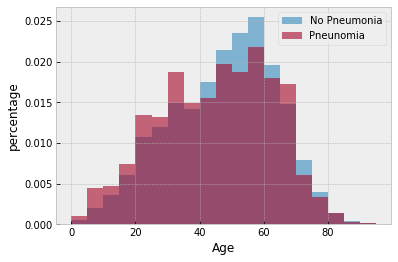

In [54]:
# Age distribution with and without pneunomia
df.groupby(['Pneumonia'])['Patient Age'].hist(bins=np.arange(0,100,5), density=True, alpha=0.6)
plt.legend(['No Pneumonia','Pneunomia'])
plt.xlabel('Age')
plt.ylabel('percentage')
df.groupby(['Pneumonia'])['Patient Age'].describe()

No remarkable differences for Pneumonia vis a vis Patient Age and Follow-Up numbers.  Pneumonia affects those of all ages.  Those with Pneumonia have more follow-ups.

#### Number of Diseases Per Patient - Pneumonia vs No Pneumonia

In [55]:
Findings = df[df['No Finding']==0]

In [56]:
No_Finding = df[df['No Finding']==1]
Pneumo = df[(df['No Finding']==0) & (df['Pneumonia']==1)]
Other_Finding = df[(df['No Finding']==0) & (df['Pneumonia']==0)]

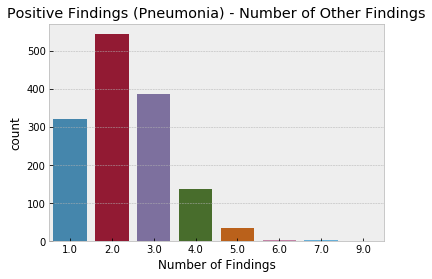

In [57]:
ax = sns.countplot(Pneumo[labels].sum(axis=1));
ax.set(xlabel='Number of Findings', ylabel='count')
plt.title('Positive Findings (Pneumonia) - Number of Other Findings');

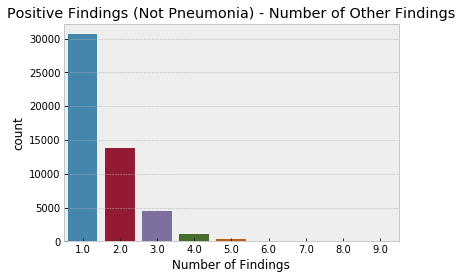

In [58]:
ax = sns.countplot(Other_Finding[labels].sum(axis=1));
ax.set(xlabel='Number of Findings', ylabel='count')
plt.title('Positive Findings (Not Pneumonia) - Number of Other Findings');

Those found to have pneumonia are more likely to have comorbidities found than those that are diagnosed with other diseases (found to mostly have just the one disease).

## Pixel Manipulation and Intensity Profiles

In [59]:
# get data
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [60]:
# create binary features per disease type
ds = data_sample.copy()
for disease in labels:
    ds[disease] = ds['Finding Labels'].map(lambda x: 1.0 if disease in x else 0)
print(ds.shape)
ds.head(2)

(5606, 26)


Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   

   Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0        1.0       0.0     0.0           1.0   0.0         0.0     0.0   
1        1.0       0.0     0.0           0.0   0.0         0.0     0.0   

   Pleural_Thickening  Pneumonia  Pneumothorax  
0                 1.0        0.0           1.0  
1                 0.0        0.0           0.0  

[2 rows x 26 columns]

In [61]:
# save image path in dataframe
ds['img_path'] = ds['Image Index'].apply(lambda x: all_image_paths[x])
ds.head(2)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   

   Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0       0.0     0.0           1.0   0.0         0.0     0.0   
1       0.0     0.0           0.0   0.0         0.0     0.0   

   Pleural_Thickening  Pneumonia  Pneumothorax  \
0                 1.0        0.0           1.0   
1                 0.0        0.0           0.0   

                                  img_path  
0  data/images_001/images/00000013_005.png  
1  data/images_001/images/00000013_026.png  

[2 rows x 27 columns]

In [62]:
# Find the number of cases with a single finding
single_disease = ds[ds[labels].sum(axis=1)==1]
print(single_disease.shape)
single_disease.sample(2)

(4626, 27)


Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
674  00003499_001.png     No Finding            1        3499        048Y   
84   00000468_045.png     No Finding           45         468        023Y   

    Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
674              M            PA                2021                 2021   
84               M            AP                2048                 2500   

     OriginalImagePixelSpacing_x  ...  Fibrosis  Hernia  Infiltration  Mass  \
674                     0.194311  ...       0.0     0.0           0.0   0.0   
84                      0.171000  ...       0.0     0.0           0.0   0.0   

     No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
674         1.0     0.0                 0.0        0.0           0.0   
84          1.0     0.0                 0.0        0.0           0.0   

                                    img_path  
674  data/images_002/images/00003499_001.png  
84   data/images_001/images/00000468_045.png  

[2 rows x 27 columns]

In [63]:
# Find the number of cases with multiple findings
multi_disease = ds[ds[labels].sum(axis=1)>1]
print(multi_disease.shape)
multi_disease.sample(2)

(980, 27)


Image Index                            Finding Labels  Follow-up #  \
2724  00013659_029.png  Fibrosis|Infiltration|Pleural_Thickening           29   
1781  00009403_005.png                       Nodule|Pneumothorax            5   

      Patient ID Patient Age Patient Gender View Position  OriginalImageWidth  \
2724       13659        064Y              F            AP                3056   
1781        9403        057Y              M            PA                2500   

      OriginalImageHeight  OriginalImagePixelSpacing_x  ...  Fibrosis  Hernia  \
2724                 2544                        0.139  ...       1.0     0.0   
1781                 2048                        0.168  ...       0.0     0.0   

      Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
2724           1.0   0.0         0.0     0.0                 1.0        0.0   
1781           0.0   0.0         0.0     1.0                 0.0        0.0   

      Pneumothorax                                 img_path  
2724           0.0  data/images_006/images/00013659_029.png  
1781           1.0  data/images_005/images/00009403_005.png  

[2 rows x 27 columns]

In [75]:
def get_samples(labels, df, sample_no=1):
    sample_dict = {}
    for x in labels:
        if (len(df[df[x]==1])>0):
            view = df[df[x]==1].sample(sample_no) # 5
            sample_dict[x] = view.index.values # no []
    return sample_dict

# samples of 5
samples_group = get_samples(labels, ds, 5)
singles_group = get_samples(labels, single_disease, 5)
multis_group = get_samples(labels, multi_disease, 5)

In [76]:
samples_group

{'Atelectasis': array([ 401, 2507, 4139,  270, 3207]),
 'Cardiomegaly': array([ 973,   22, 2774, 2639,  756]),
 'Consolidation': array([ 900, 2496, 1919, 5084, 3439]),
 'Edema': array([1923, 1466, 4971, 1582, 4520]),
 'Effusion': array([4508, 3409, 1377, 2003, 2316]),
 'Emphysema': array([ 511, 1867, 1629, 2761, 4274]),
 'Fibrosis': array([3046, 1296, 2770,  532, 4708]),
 'Hernia': array([1254, 1479, 2546, 1775, 1662]),
 'Infiltration': array([2550,  682, 2291, 2774, 1133]),
 'Mass': array([2191, 3168, 3262, 3817, 5198]),
 'No Finding': array([ 156, 4790, 1869, 2721, 2598]),
 'Nodule': array([4896, 1540, 2771, 2294,  346]),
 'Pleural_Thickening': array([4103, 5289, 2357, 2530, 5357]),
 'Pneumonia': array([2791, 2148, 3858, 2183, 4046]),
 'Pneumothorax': array([4224, 3146,  267, 4449, 1946])}

In [77]:
ds.loc[list(singles_group['Pneumonia'])]

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
4033  00019865_013.png      Pneumonia           13       19865        022Y   
3858  00019021_001.png      Pneumonia            1       19021        044Y   
2534  00012733_000.png      Pneumonia            0       12733        073Y   
2422  00012158_025.png      Pneumonia           25       12158        047Y   
2286  00011702_043.png      Pneumonia           43       11702        026Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
4033              M            PA                2786                 2739   
3858              M            PA                2992                 2991   
2534              M            PA                2992                 2991   
2422              F            PA                2992                 2991   
2286              F            AP                2500                 2048   

      OriginalImagePixelSpacing_x  ...  Fibrosis  Hernia  Infiltration  Mass  \
4033                        0.143  ...       0.0     0.0           0.0   0.0   
3858                        0.143  ...       0.0     0.0           0.0   0.0   
2534                        0.143  ...       0.0     0.0           0.0   0.0   
2422                        0.143  ...       0.0     0.0           0.0   0.0   
2286                        0.168  ...       0.0     0.0           0.0   0.0   

      No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
4033         0.0     0.0                 0.0        1.0           0.0   
3858         0.0     0.0                 0.0        1.0           0.0   
2534         0.0     0.0                 0.0        1.0           0.0   
2422         0.0     0.0                 0.0        1.0           0.0   
2286         0.0     0.0                 0.0        1.0           0.0   

                                     img_path  
4033  data/images_009/images/00019865_013.png  
3858  data/images_009/images/00019021_001.png  
2534  data/images_006/images/00012733_000.png  
2422  data/images_006/images/00012158_025.png  
2286  data/images_006/images/00011702_043.png  

[5 rows x 27 columns]

In [67]:
ds.loc[list(multis_group['Pneumonia'])]

Image Index                                     Finding Labels  \
3057  00015069_000.png                             Infiltration|Pneumonia   
1871  00009863_007.png  Atelectasis|Consolidation|Edema|Infiltration|P...   
1889  00009925_012.png  Atelectasis|Edema|Effusion|Infiltration|Pneumonia   
4322  00021289_000.png                Consolidation|Mass|Nodule|Pneumonia   
5016  00026560_010.png               Cardiomegaly|Consolidation|Pneumonia   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
3057            0       15069        025Y              M            PA   
1871            7        9863        040Y              F            AP   
1889           12        9925        056Y              M            AP   
4322            0       21289        040Y              F            AP   
5016           10       26560        046Y              F            AP   

      OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
3057                2048                 2500                        0.168   
1871                2500                 2048                        0.168   
1889                2500                 2048                        0.168   
4322                3056                 2544                        0.139   
5016                3056                 2544                        0.139   

      ...  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
3057  ...       0.0     0.0           1.0   0.0         0.0     0.0   
1871  ...       0.0     0.0           1.0   0.0         0.0     0.0   
1889  ...       0.0     0.0           1.0   0.0         0.0     0.0   
4322  ...       0.0     0.0           0.0   1.0         0.0     1.0   
5016  ...       0.0     0.0           0.0   0.0         0.0     0.0   

      Pleural_Thickening  Pneumonia  Pneumothorax  \
3057                 0.0        1.0           0.0   
1871                 0.0        1.0           0.0   
1889                 0.0        1.0           0.0   
4322                 0.0        1.0           0.0   
5016                 0.0        1.0           0.0   

                                     img_path  
3057  data/images_007/images/00015069_000.png  
1871  data/images_005/images/00009863_007.png  
1889  data/images_005/images/00009925_012.png  
4322  data/images_010/images/00021289_000.png  
5016  data/images_011/images/00026560_010.png  

[5 rows x 27 columns]

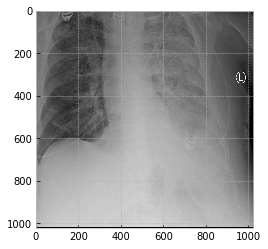

In [68]:
plt.imshow(io.imread(ds.loc[samples_group['Pneumonia'][0]]['img_path']), cmap='gray')

### Masking and Standardizing Intensity Profiles

We will use Otsu's method to filter out the background from the foreground to get more accurate representation of image.  This will minimize within-class variance and maximize between-class variance.  Goal is to create most  variance between classes and reduce within classes by filtering out irrelevant pixels (e.g. extremes of dark and light).

In [69]:
def get_otsu_mask(img_array, lo_thresh=0, hi_thresh=255):
    # retain pixels above and below threshold
    mask = (img_array > lo_thresh) & (img_array < hi_thresh)
    # black/white (0/255) img mask - visualization of respective disallowed/allowed pixels)
    mask_img = mask * 255  
    # mask applied to original img_array (will return only pixels between thresholds)
    masked_array = img_array[mask]
    # return mask visualization and masked img_array
    return (mask_img, masked_array)

In [70]:
def standardize(x_array):
    x_mean = x_array.mean()
    x_std = x_array.std()
    return (x_array - x_mean)/x_std

### Pneumonia Patients
#### View variations within the set of patients labeled with pneumonia

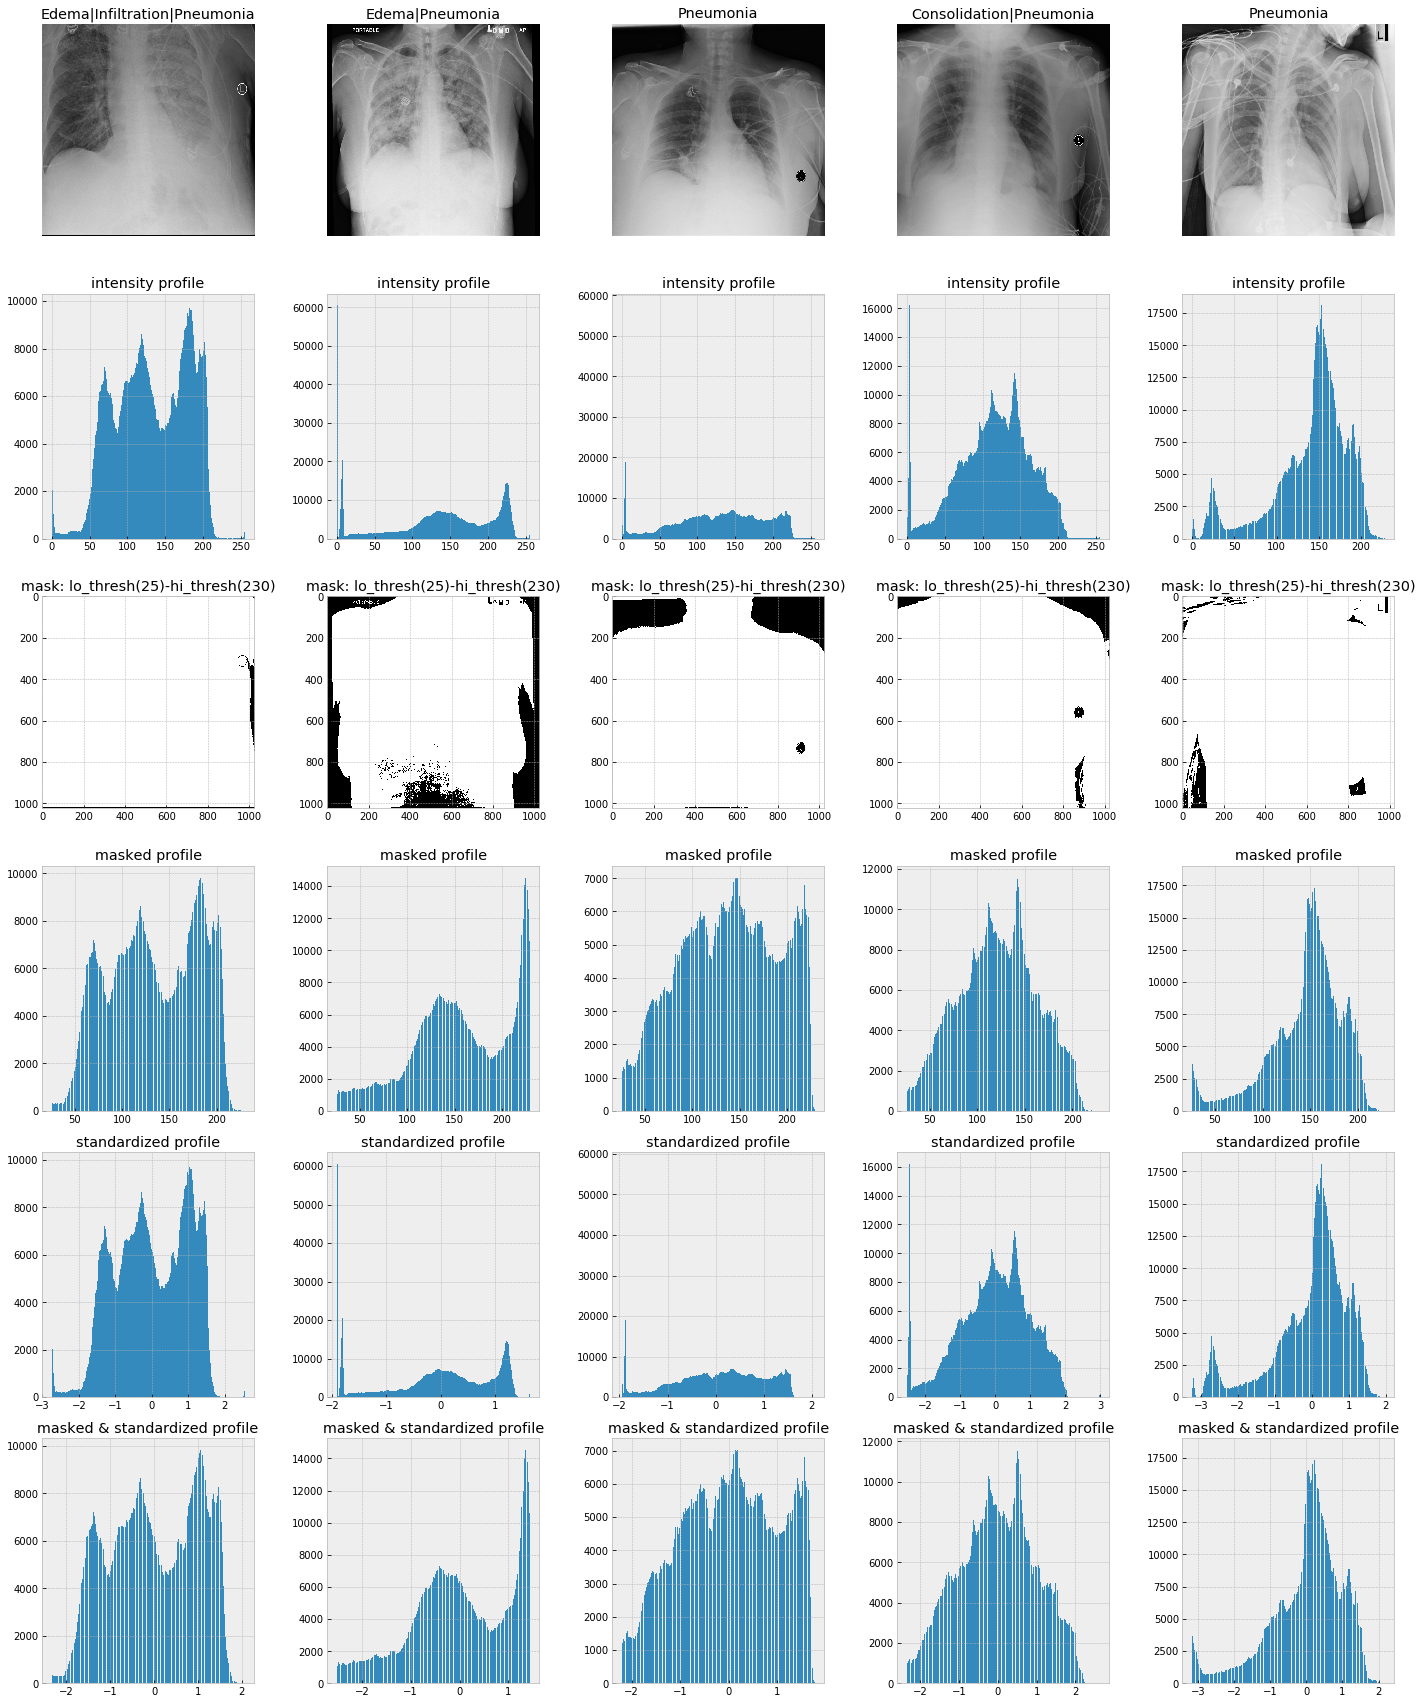

In [71]:
lo_thresh, hi_thresh = (25,230)
fig, axs = plt.subplots(6, 5,  figsize=(20,24))
plt.style.use('bmh')
for i in range(0,5):
    
    #fig.tight_layout()
    img_array = io.imread(ds.loc[samples_group['Pneumonia'][i]]['img_path'])
    
    # raw image
    axs[0, i].imshow(img_array, cmap="gray")
    axs[0, i].set_title(ds.loc[samples_group['Pneumonia'][i]]['Finding Labels'])
    axs[0, i].axis('Off')
    
    # raw histogram - intensity profile
    axs[1, i].hist(img_array.ravel(), bins=256)
    axs[1, i].set_title('intensity profile')
    
    # otsu mask
    axs[2, i].imshow(get_otsu_mask(img_array,lo_thresh,hi_thresh)[0], cmap='gray')
    axs[2, i].set_title(f'mask: lo_thresh({lo_thresh})-hi_thresh({hi_thresh})')
    
    # otsu masked histogram - intensity profile
    axs[3, i].hist(get_otsu_mask(img_array,lo_thresh,hi_thresh)[1].ravel(), bins=256)
    axs[3, i].set_title('masked profile')
    
    # show standardized pre and post mask images
    axs[4, i].hist(standardize(img_array.ravel()), bins=256)
    axs[4, i].set_title('standardized profile')
    
    axs[5, i].hist(standardize(get_otsu_mask(img_array,lo_thresh,hi_thresh)[1].ravel()), bins=256)
    axs[5, i].set_title(f"masked & standardized profile")
fig.tight_layout()
plt.show()

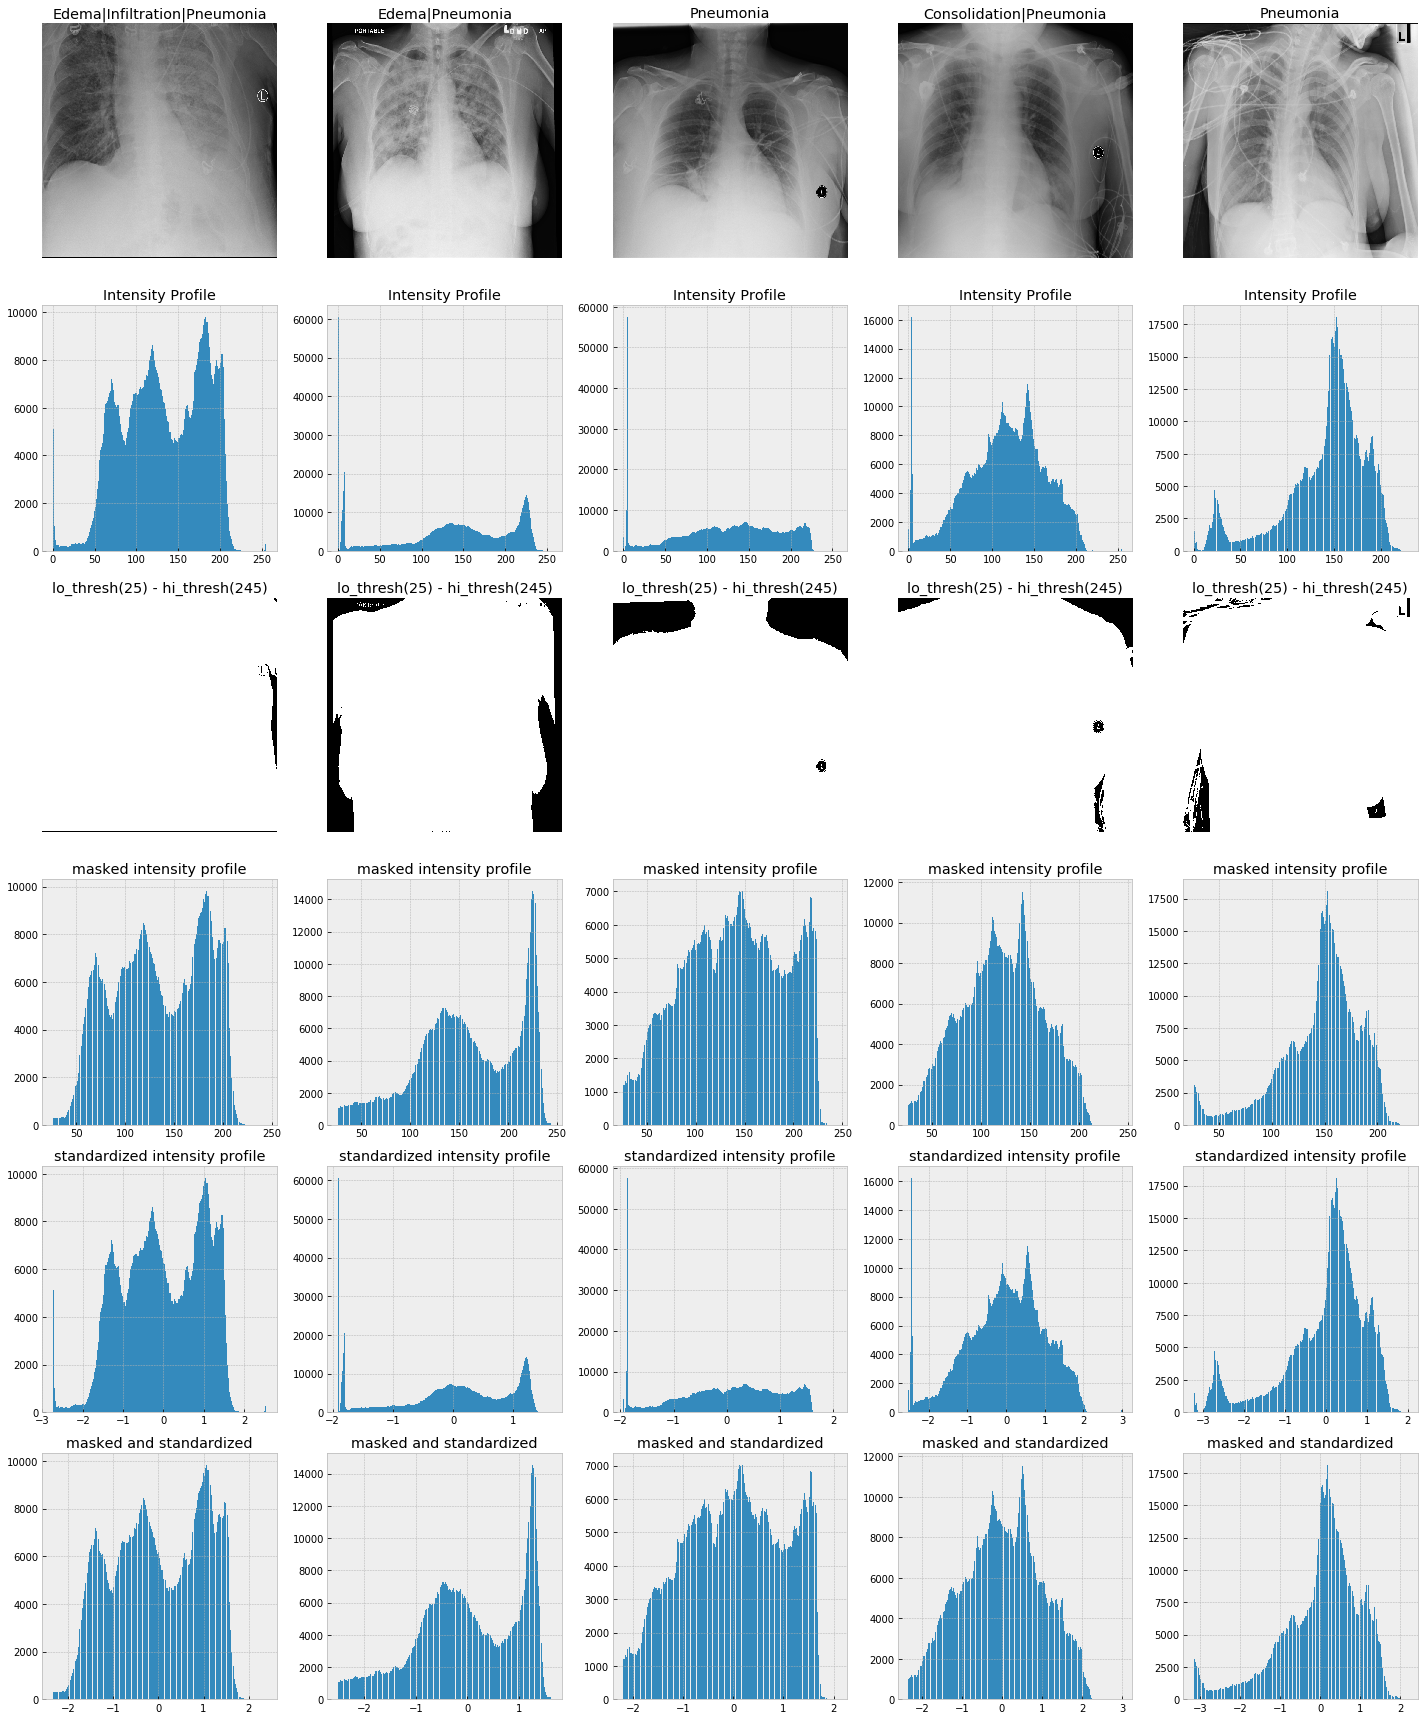

In [73]:
lo_thresh, hi_thresh = (25,245)
fig, axs = plt.subplots(6, 5,  figsize=(20,24))
for i in range(0,5):
    
    fig.tight_layout()
    img_array = io.imread(ds.loc[samples_group['Pneumonia'][i]]['img_path'])
    
    # raw image
    axs[0, i].imshow(img_array, cmap="gray")
    axs[0, i].set_title(ds.loc[samples_group['Pneumonia'][i]]['Finding Labels'])
    axs[0, i].axis('Off')
    
    # raw histogram - intensity profile
    axs[1, i].hist(img_array.ravel(), bins=256)
    axs[1, i].set_title('Intensity Profile')

    # otsu mask
    axs[2, i].imshow(get_otsu_mask(img_array, lo_thresh, hi_thresh)[0], cmap='gray')
    axs[2, i].set_title(f'lo_thresh({lo_thresh}) - hi_thresh({hi_thresh})')
    axs[2, i].axis('Off')
    
    # otsu masked histogram - intensity profile
    axs[3, i].hist(get_otsu_mask(img_array, lo_thresh, hi_thresh)[1].ravel(), bins=256)
    axs[3, i].set_title('masked intensity profile')
    
    # show standardized pre and post mask images
    axs[4, i].hist(standardize(img_array.ravel()), bins=256)
    axs[4, i].set_title('standardized intensity profile')                         
    axs[5, i].hist(standardize(get_otsu_mask(img_array, lo_thresh, hi_thresh)[1].ravel()), bins=256)
    axs[5, i].set_title('masked and standardized')
    #axs[5, i].set_title(f"{ds.loc[samples_group['Pneumonia'][i]]['Finding Labels']}")

### Single Finding
#### View variations within the set of patients labeled with one disease label

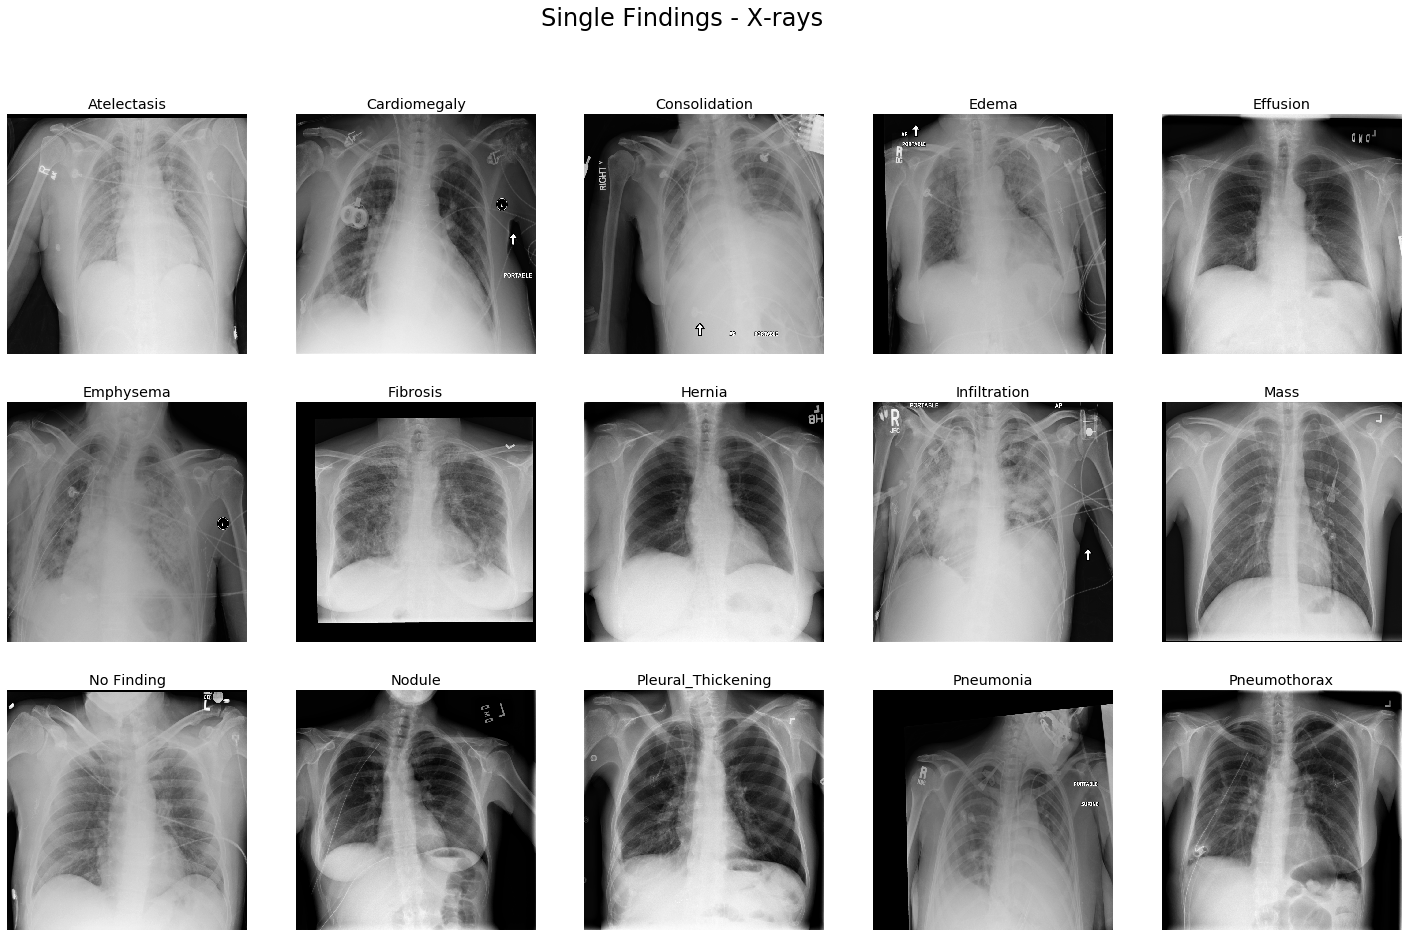

In [78]:
# View Single Finding Label instances - Random Spot Check - Images
singles = get_samples(labels, single_disease)

fig=plt.figure(figsize=(25, 15))
cols = 5
rows = 3

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    img_array = ds.loc[singles[list(singles.keys())[i-1]][0]]['img_path']
    plt.imshow(io.imread(img_array), cmap="gray")
    plt.title(list(singles.keys())[i-1])
    plt.axis('off')
plt.suptitle('Single Findings - X-rays', fontsize='24')
plt.show()

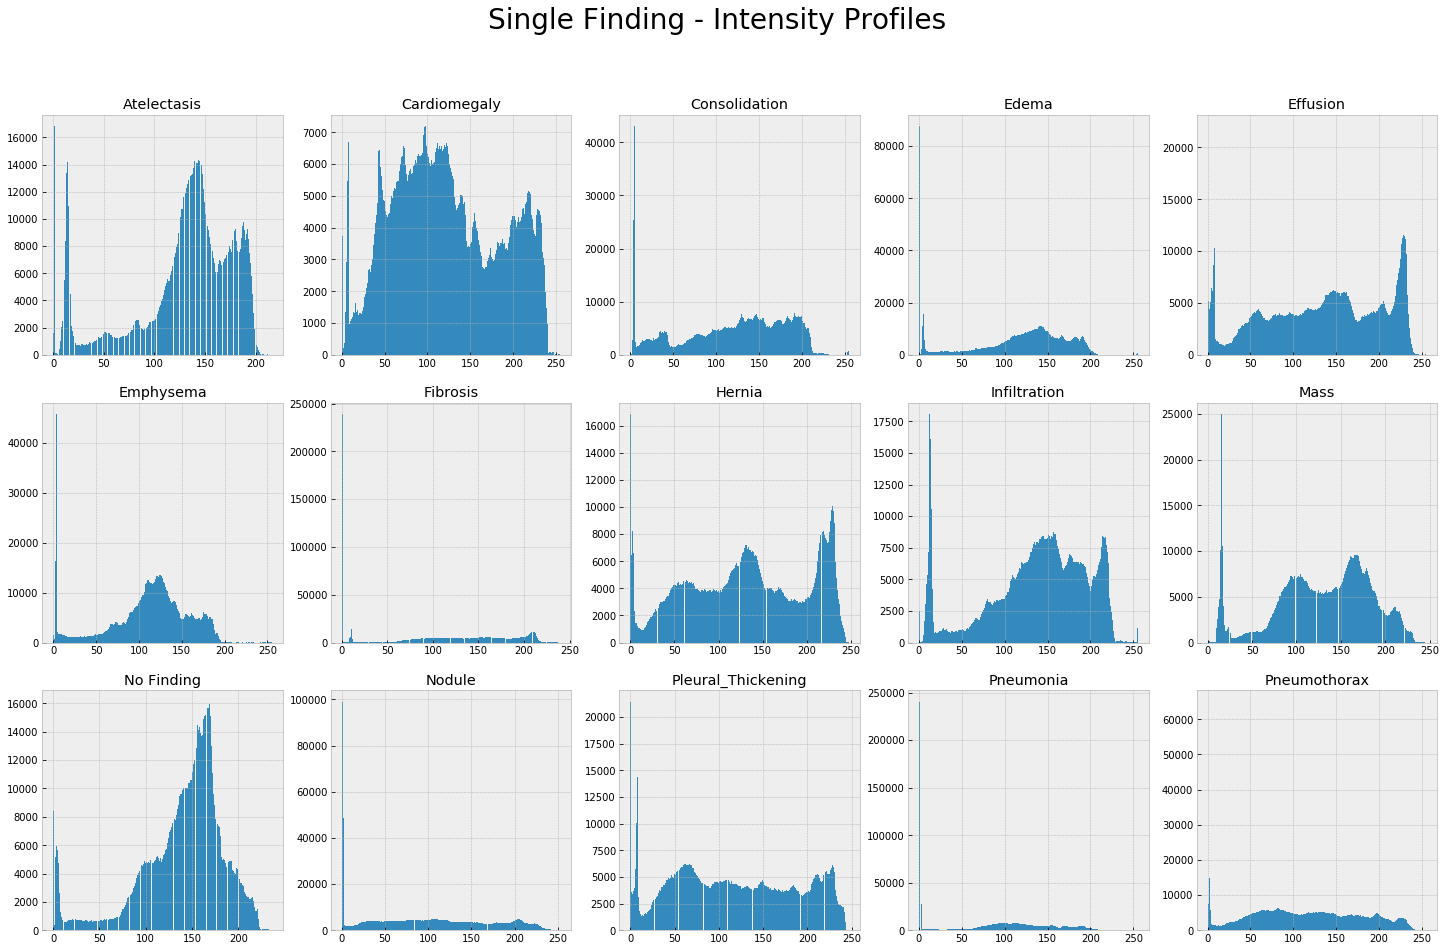

In [79]:
# View Single Finding Label instances - Random Spot Check - Intensity Profiles
lo_thresh, hi_thresh = (50,240)
fig=plt.figure(figsize=(25, 15))
cols = 5
rows = 3
for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    img_array = ds.loc[singles[list(singles.keys())[i-1]][0]]['img_path']
    plt.hist(io.imread(ds.loc[singles[list(singles.keys())[i-1]][0]]['img_path']).ravel(), bins=256)
    plt.title(list(singles.keys())[i-1])
plt.suptitle('Single Finding - Intensity Profiles', fontsize='28')
plt.show()

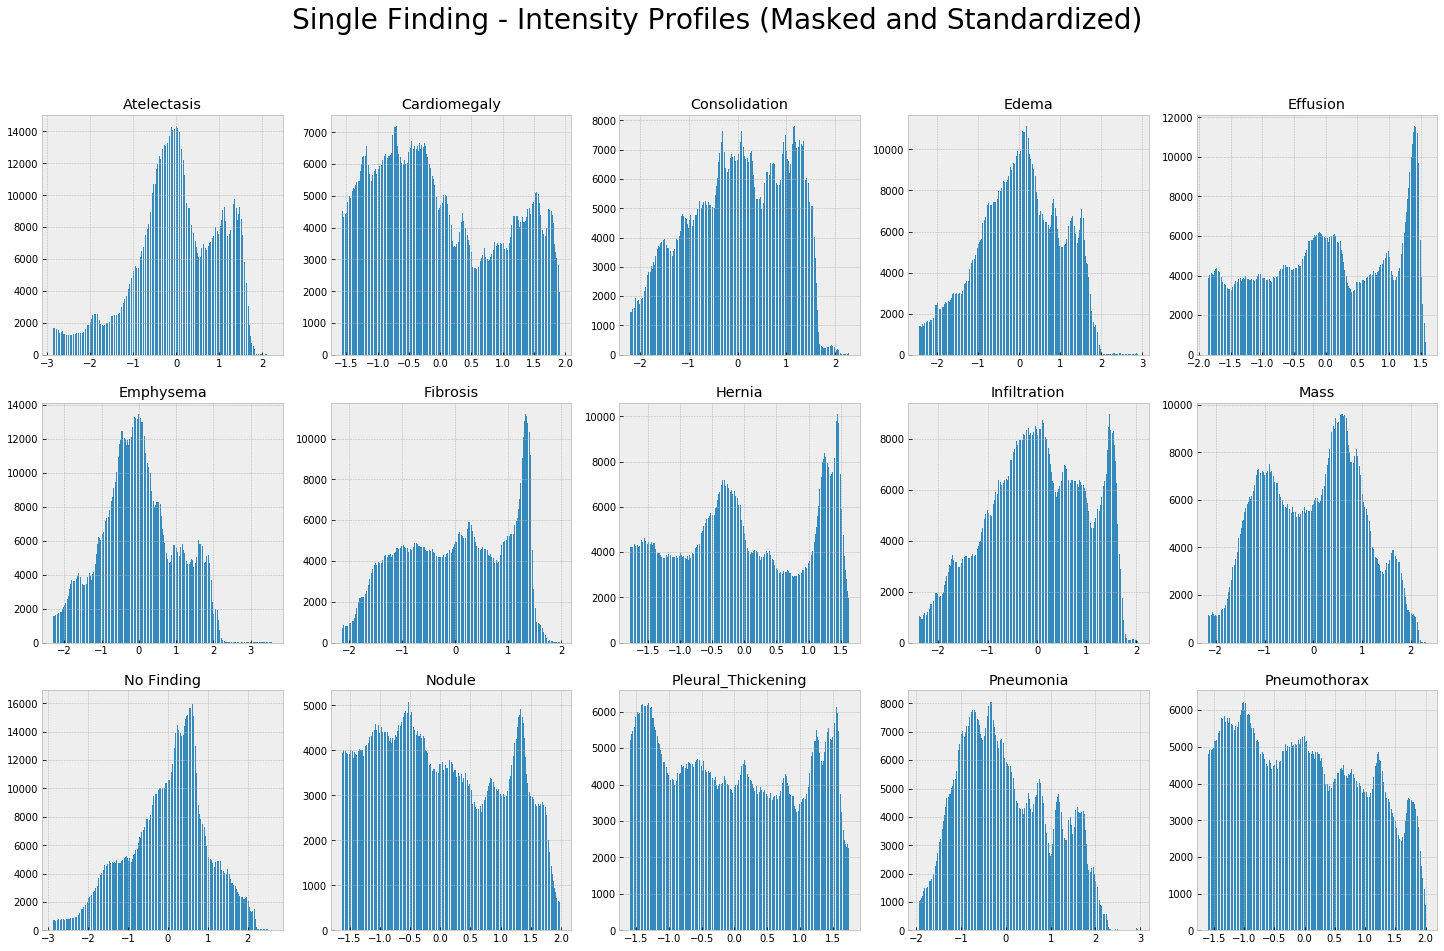

In [81]:
# View Single Finding Label instances - Random Spot Check - Intensity Profiles
lo_thresh, hi_thresh = (50,240)
fig=plt.figure(figsize=(25, 15))
cols = 5
rows = 3
for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    img_array = io.imread(ds.loc[singles[list(singles.keys())[i-1]][0]]['img_path'])
    plt.hist(standardize(get_otsu_mask(img_array, lo_thresh, hi_thresh)[1].ravel()), bins=256)
   
    plt.title(list(singles.keys())[i-1])
plt.suptitle('Single Finding - Intensity Profiles (Masked and Standardized)', fontsize='28')
plt.show()



### Multiple Findings
#### View variations within the set of patients labeled with multiple disease labels 
Note: There are only 14 groups here represented (one for each disease excluding 'No Finding' - comorbities may vary)

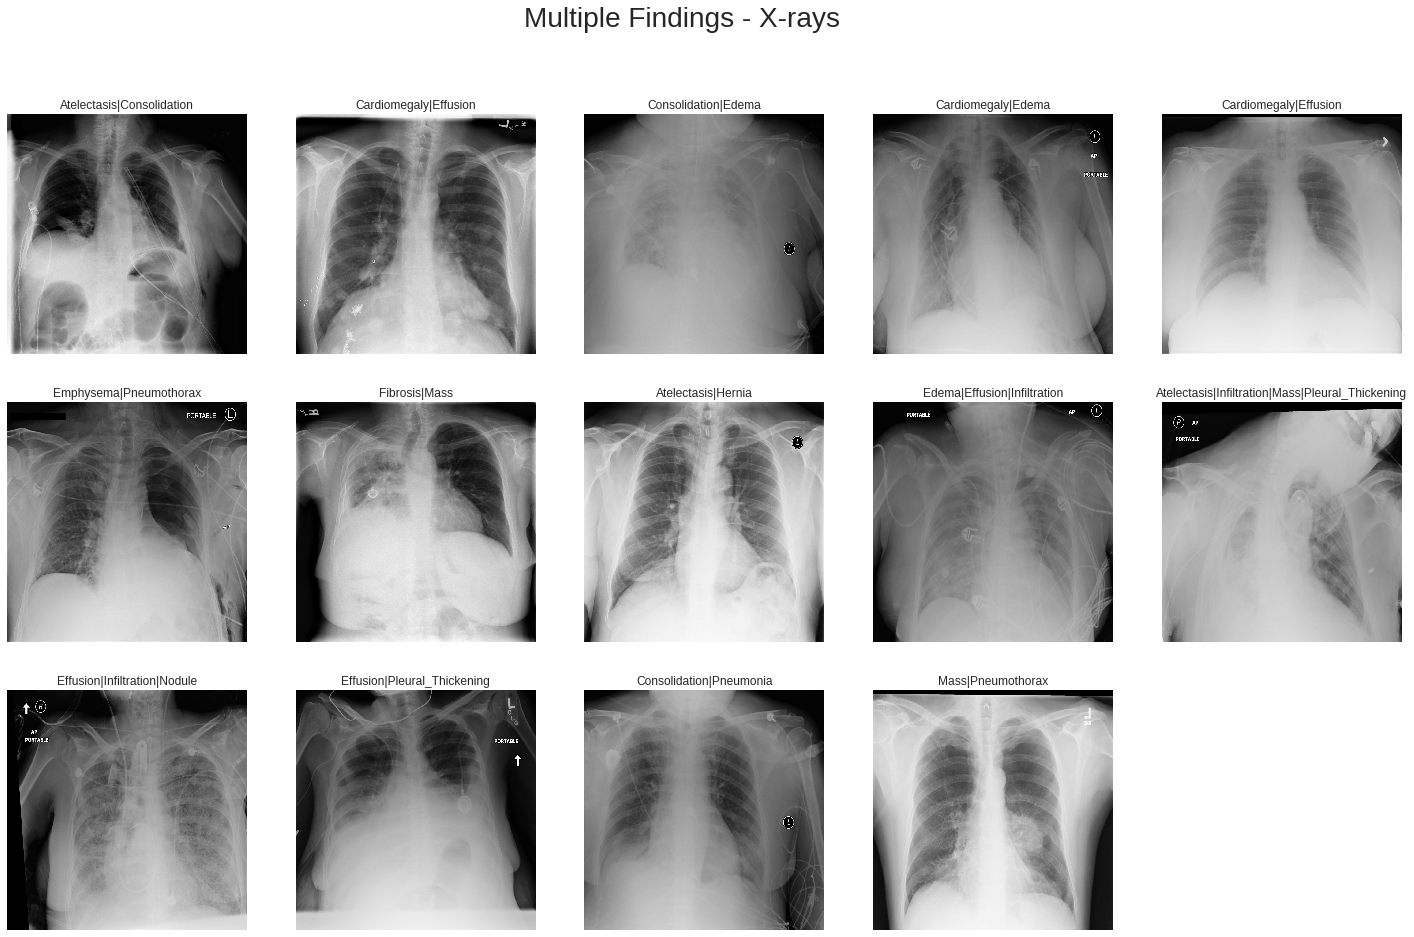

In [87]:
# View Multiple Finding Lable instances - Random Spot Check - Intensity Profiles
multis = get_samples(labels, multi_disease)

fig=plt.figure(figsize=(25, 15))
fig.tight_layout()
cols = 5
rows = 3
# drop range # as no case where 'No Finding' has a multi-label incidence
for i in range(1, cols*rows):
    fig.add_subplot(rows, cols, i)
    plt.imshow(io.imread(ds.loc[multis[list(multis.keys())[i-1]][0]]['img_path']), cmap="gray")
    plt.title(ds.loc[multis[list(multis.keys())[i-1]][0]]['Finding Labels'])
    plt.axis('off')
plt.suptitle('Multiple Findings - X-rays', fontsize='28')
plt.show()

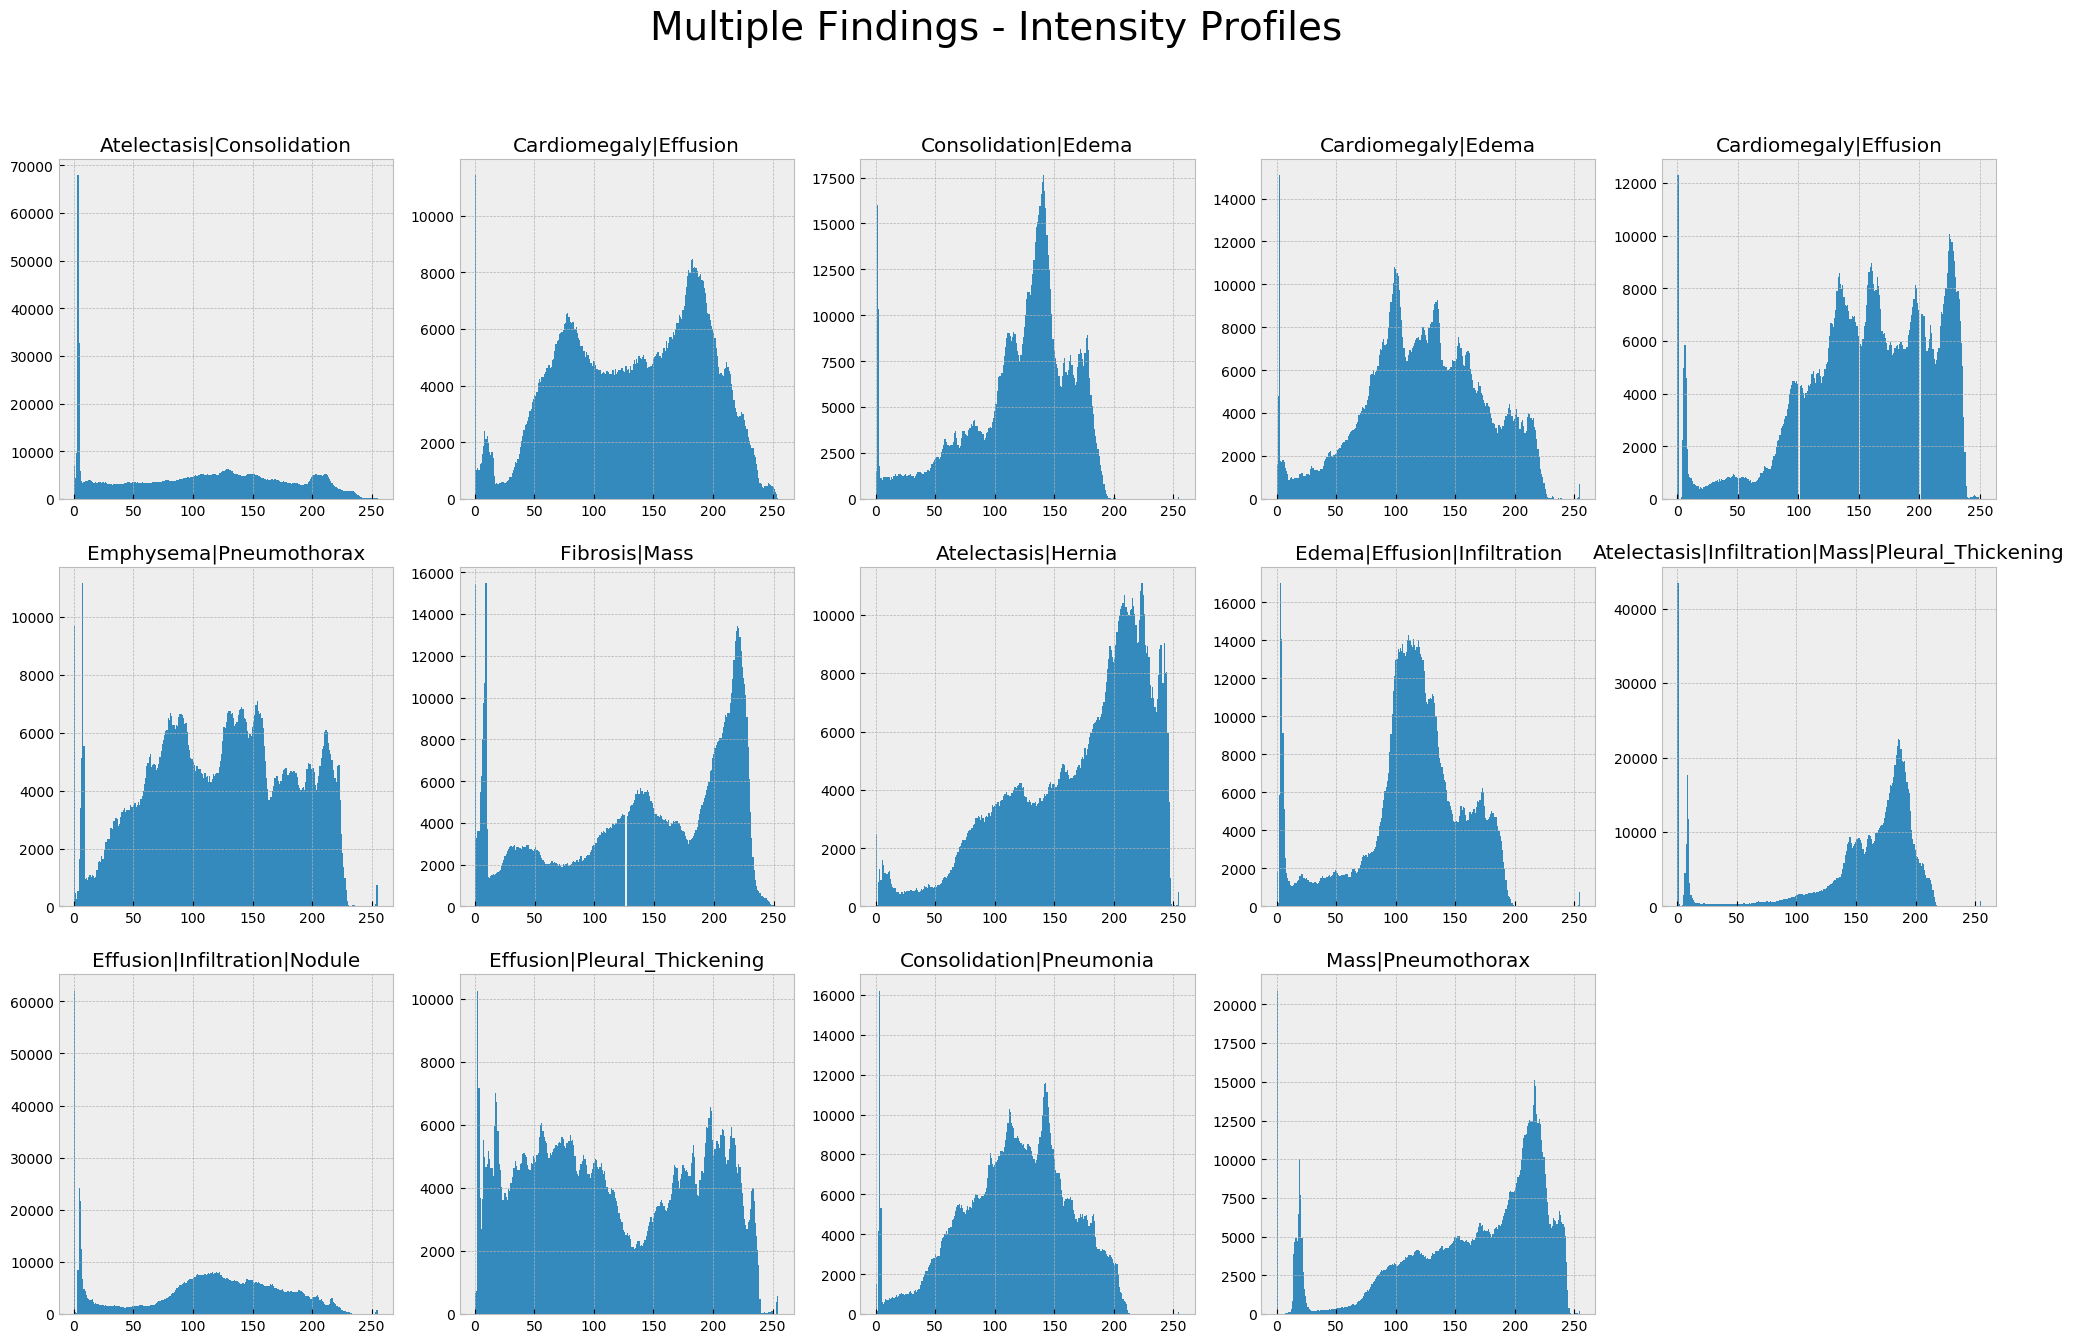

In [130]:
# View Muliple Finding Lable instances - Random Spot Check - Intensity Profiles
fig=plt.figure(figsize=(25, 15))
fig.tight_layout()
plt.style.use('bmh')
cols = 5
rows = 3
# drop range # as no case where 'No Finding' has a multi-label incidence
for i in range(1, cols*rows):
    fig.add_subplot(rows, cols, i)
    img_array = io.imread(ds.loc[multis[list(multis.keys())[i-1]][0]]['img_path'])
    plt.hist(io.imread(ds.loc[multis[list(multis.keys())[i-1]][0]]['img_path']).ravel(), bins=256)
    plt.title(ds.loc[multis[list(multis.keys())[i-1]][0]]['Finding Labels'])
plt.suptitle('Multiple Findings - Intensity Profiles', fontsize='28')
plt.show()

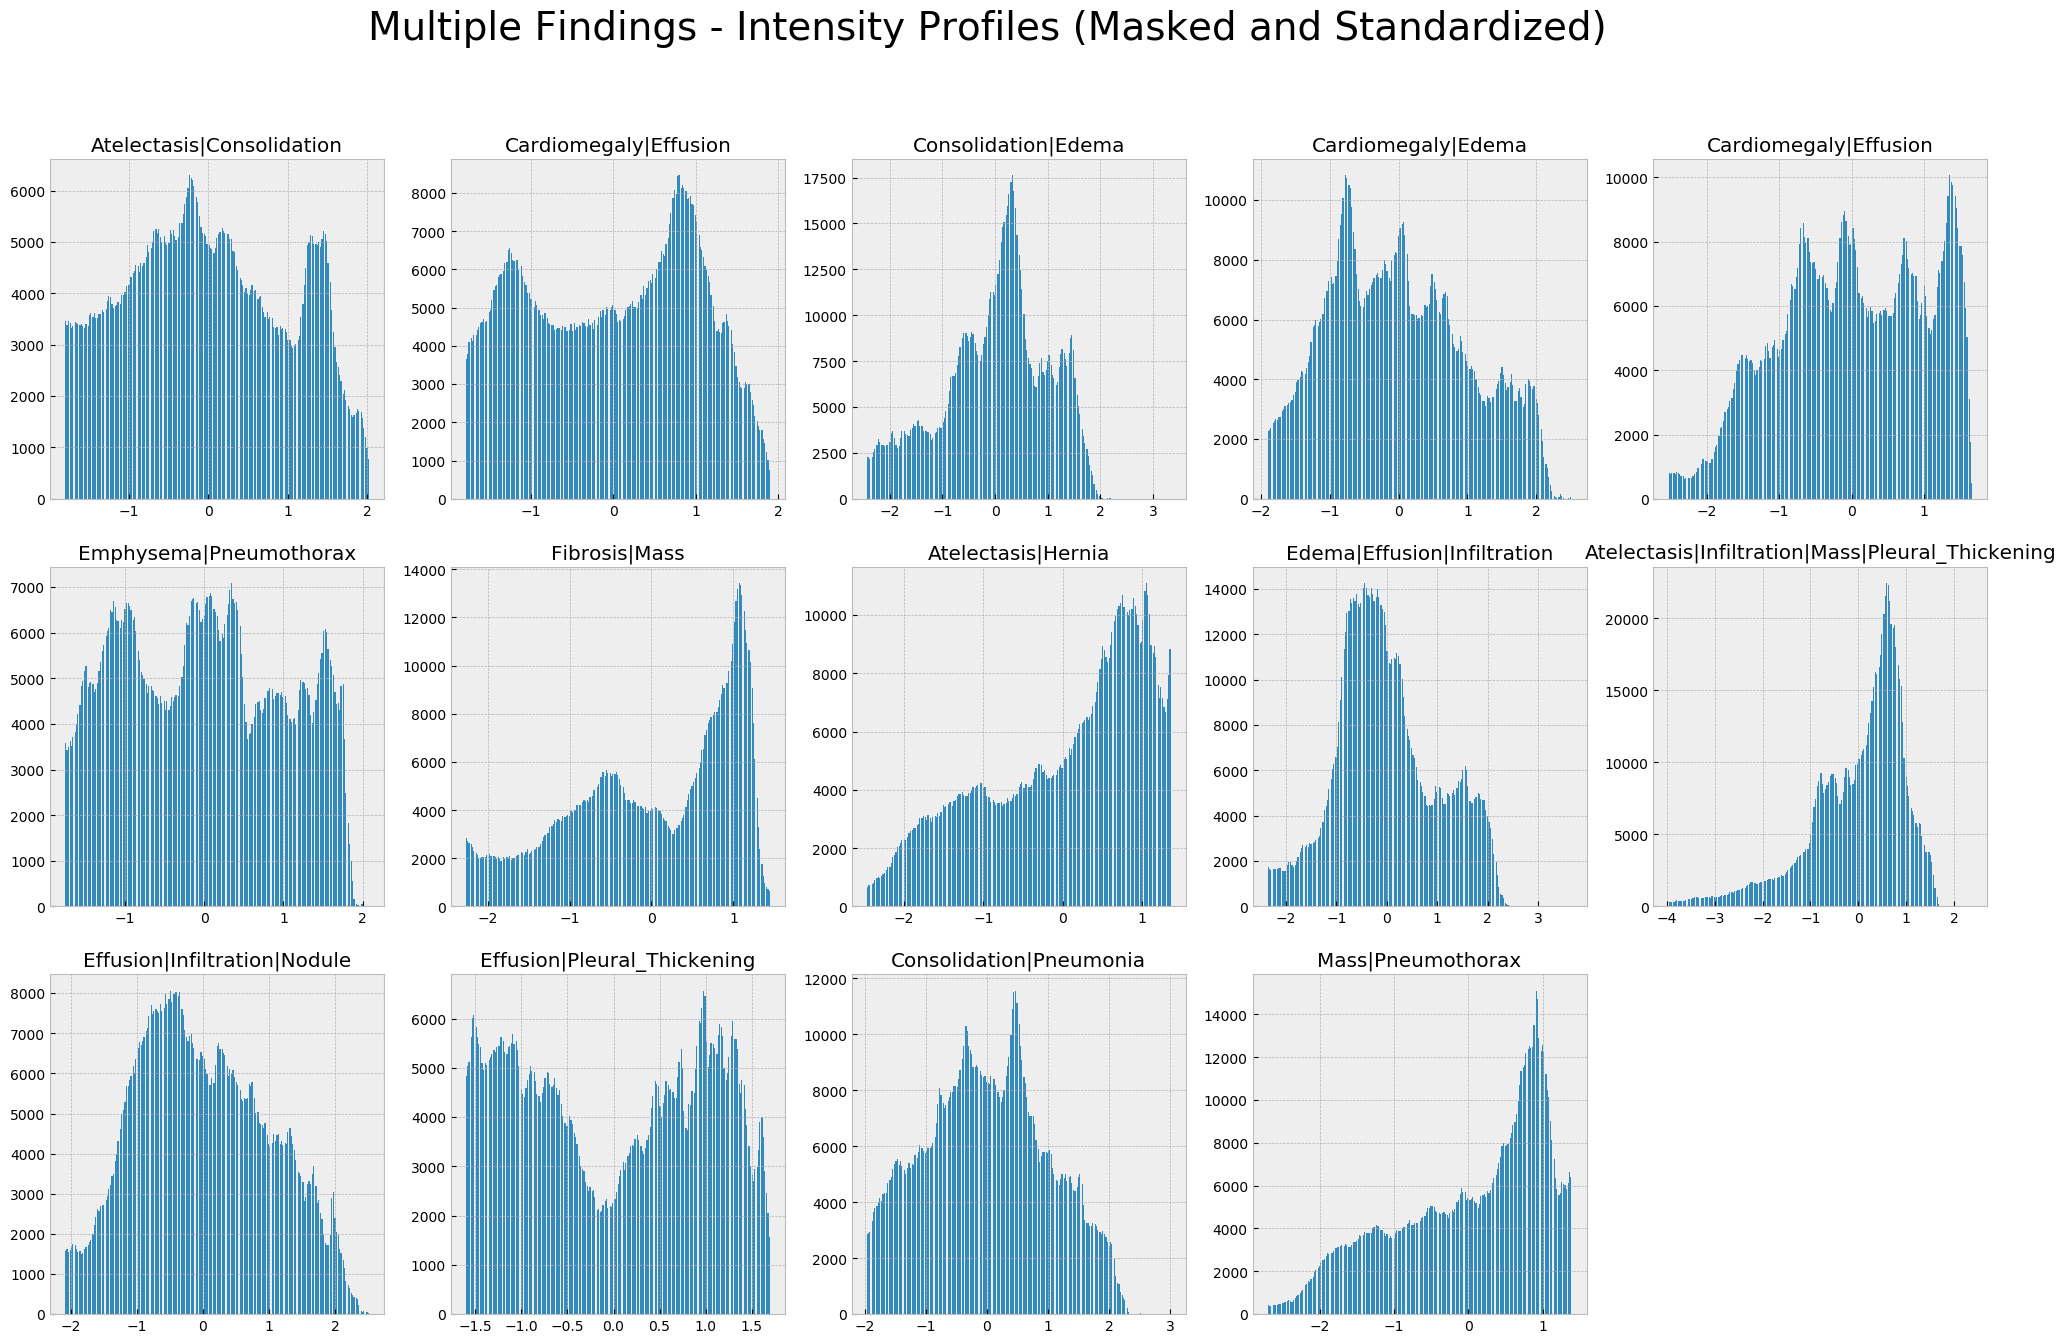

In [131]:
# View Muliple Finding Lable instances - Random Spot Check - Intensity Profiles
fig=plt.figure(figsize=(25, 15))
fig.tight_layout()
plt.style.use('bmh')
cols = 5
rows = 3
# drop range # as no case where 'No Finding' has a multi-label incidence
for i in range(1, cols*rows):
    fig.add_subplot(rows, cols, i)
    img_array = io.imread(ds.loc[multis[list(multis.keys())[i-1]][0]]['img_path'])
    plt.hist(standardize(get_otsu_mask(img_array, lo_thresh, hi_thresh)[1].ravel()), bins=256)
    plt.title(ds.loc[multis[list(multis.keys())[i-1]][0]]['Finding Labels'])
plt.suptitle('Multiple Findings - Intensity Profiles (Masked and Standardized)', fontsize='28')
plt.show()

### Aggregate Intensity Profiles 
#### Showing patterns for diseases by aggregating intensity profiles for the group

In [124]:
# get aggregates for each disease
def get_agg_diseases(labels, df):
    intensities = {}
    for x in labels:
        if (len(df[df[x]==1])>0):
            intensities[x]=len(df[df[x]==1])
    return intensities

In [125]:
sample_labels = get_agg_diseases(labels, ds)
single_labels = get_agg_diseases(labels, single_disease)
mutlipe_labels = get_agg_diseases(labels, multi_disease)
print(sum(sample_labels.values()), sum(single_labels.values()), sum(mutlipe_labels.values()))
(sample_labels, single_labels, mutlipe_labels)

6978 4626 2352


({'Atelectasis': 508,
  'Cardiomegaly': 141,
  'Consolidation': 226,
  'Edema': 118,
  'Effusion': 644,
  'Emphysema': 127,
  'Fibrosis': 84,
  'Hernia': 13,
  'Infiltration': 967,
  'Mass': 284,
  'No Finding': 3044,
  'Nodule': 313,
  'Pleural_Thickening': 176,
  'Pneumonia': 62,
  'Pneumothorax': 271},
 {'Atelectasis': 192,
  'Cardiomegaly': 50,
  'Consolidation': 72,
  'Edema': 41,
  'Effusion': 203,
  'Emphysema': 42,
  'Fibrosis': 38,
  'Hernia': 5,
  'Infiltration': 503,
  'Mass': 99,
  'No Finding': 3044,
  'Nodule': 144,
  'Pleural_Thickening': 65,
  'Pneumonia': 14,
  'Pneumothorax': 114},
 {'Atelectasis': 316,
  'Cardiomegaly': 91,
  'Consolidation': 154,
  'Edema': 77,
  'Effusion': 441,
  'Emphysema': 85,
  'Fibrosis': 46,
  'Hernia': 8,
  'Infiltration': 464,
  'Mass': 185,
  'Nodule': 169,
  'Pleural_Thickening': 111,
  'Pneumonia': 48,
  'Pneumothorax': 157})

These are the respective quantities of images that we have for each disease type (may or may not be combined with another disease type):  As we have a very low number of Pneumonia labels to begin with, this doesn't look good for our study.  But, we will examine the aggregate intensities of the first 10 of each group to get a better idea for the aggregate intensity profiles.  We are bottlenecked by the Hernia classification having only (13, 5, 8) examples in the respective general sample, single disease, and multi-disease classifications.

In [90]:
samples_group = get_samples(labels, ds, 10)  # single or multiple diseases 
samples_group

{'Atelectasis': array([1911, 1098, 3916, 4843, 5000, 1763, 5295, 3647, 5079, 2535]),
 'Cardiomegaly': array([ 254, 4208,  196, 4103, 5143, 1072, 2379, 4138, 1520, 5528]),
 'Consolidation': array([5593,   88,  834, 4519, 1077, 5358, 5076, 2701,  287, 4901]),
 'Edema': array([4804, 1731, 2619,  460, 3100, 3006, 1080, 5034, 2365, 4321]),
 'Effusion': array([4353, 1489, 2418, 3283,  291, 4206, 2178, 5590, 4601, 2747]),
 'Emphysema': array([5189,  528, 5307, 3607, 2315, 5426,  398, 2929, 2326,   61]),
 'Fibrosis': array([4708, 3409,  538, 1442, 4250, 1296, 2724, 1952,  980, 3510]),
 'Hernia': array([1852, 1418, 1544, 1662, 1775, 3692, 2574, 2546, 3381, 2752]),
 'Infiltration': array([ 160, 4775, 5238,  250, 4523, 2292, 3136,  461, 2774, 5001]),
 'Mass': array([5381, 4128, 3507, 1697, 1617, 3900, 3457, 4943, 1927, 1732]),
 'No Finding': array([4716,  478, 3210, 1513, 3040, 5337, 5022, 3602,  217, 3997]),
 'Nodule': array([4212, 4146, 1577, 2810, 2959, 2367, 5317, 3046, 1605, 1311]),
 'Pleura

data/images_009/images/00018724_008.png
data/images_010/images/00021499_013.png
data/images_010/images/00021942_006.png
data/images_006/images/00013249_033.png
data/images_007/images/00015799_007.png
data/images_011/images/00027726_003.png
data/images_009/images/00019750_022.png
data/images_005/images/00009600_003.png
data/images_003/images/00004090_002.png
data/images_001/images/00001106_000.png


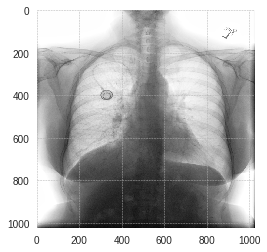

In [335]:
for x in ds.loc[samples_group['Edema']]['img_path']:
    print(x)
    plt.imshow((io.imread(x)))

In [95]:
# get aggregate intensity profiles for each disease
def get_agg_intensities(samples_dict, df, lo_thresh, hi_thresh):
    intensities = {}
    for label in samples_dict.keys():
        print(label)
        label_intensities = []
        for x in df.loc[samples_dict[label]]['img_path']:
            img_array = io.imread(x)
            mask, masked_array = get_otsu_mask(img_array, lo_thresh, hi_thresh)
            label_intensities.extend(masked_array.ravel())
        intensities[label] = np.array(label_intensities)
    return intensities

agg_intensities = get_agg_intensities(samples_group, ds, 25, 245)


Atelectasis
Cardiomegaly
Consolidation
Edema
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Mass
No Finding
Nodule
Pleural_Thickening
Pneumonia
Pneumothorax


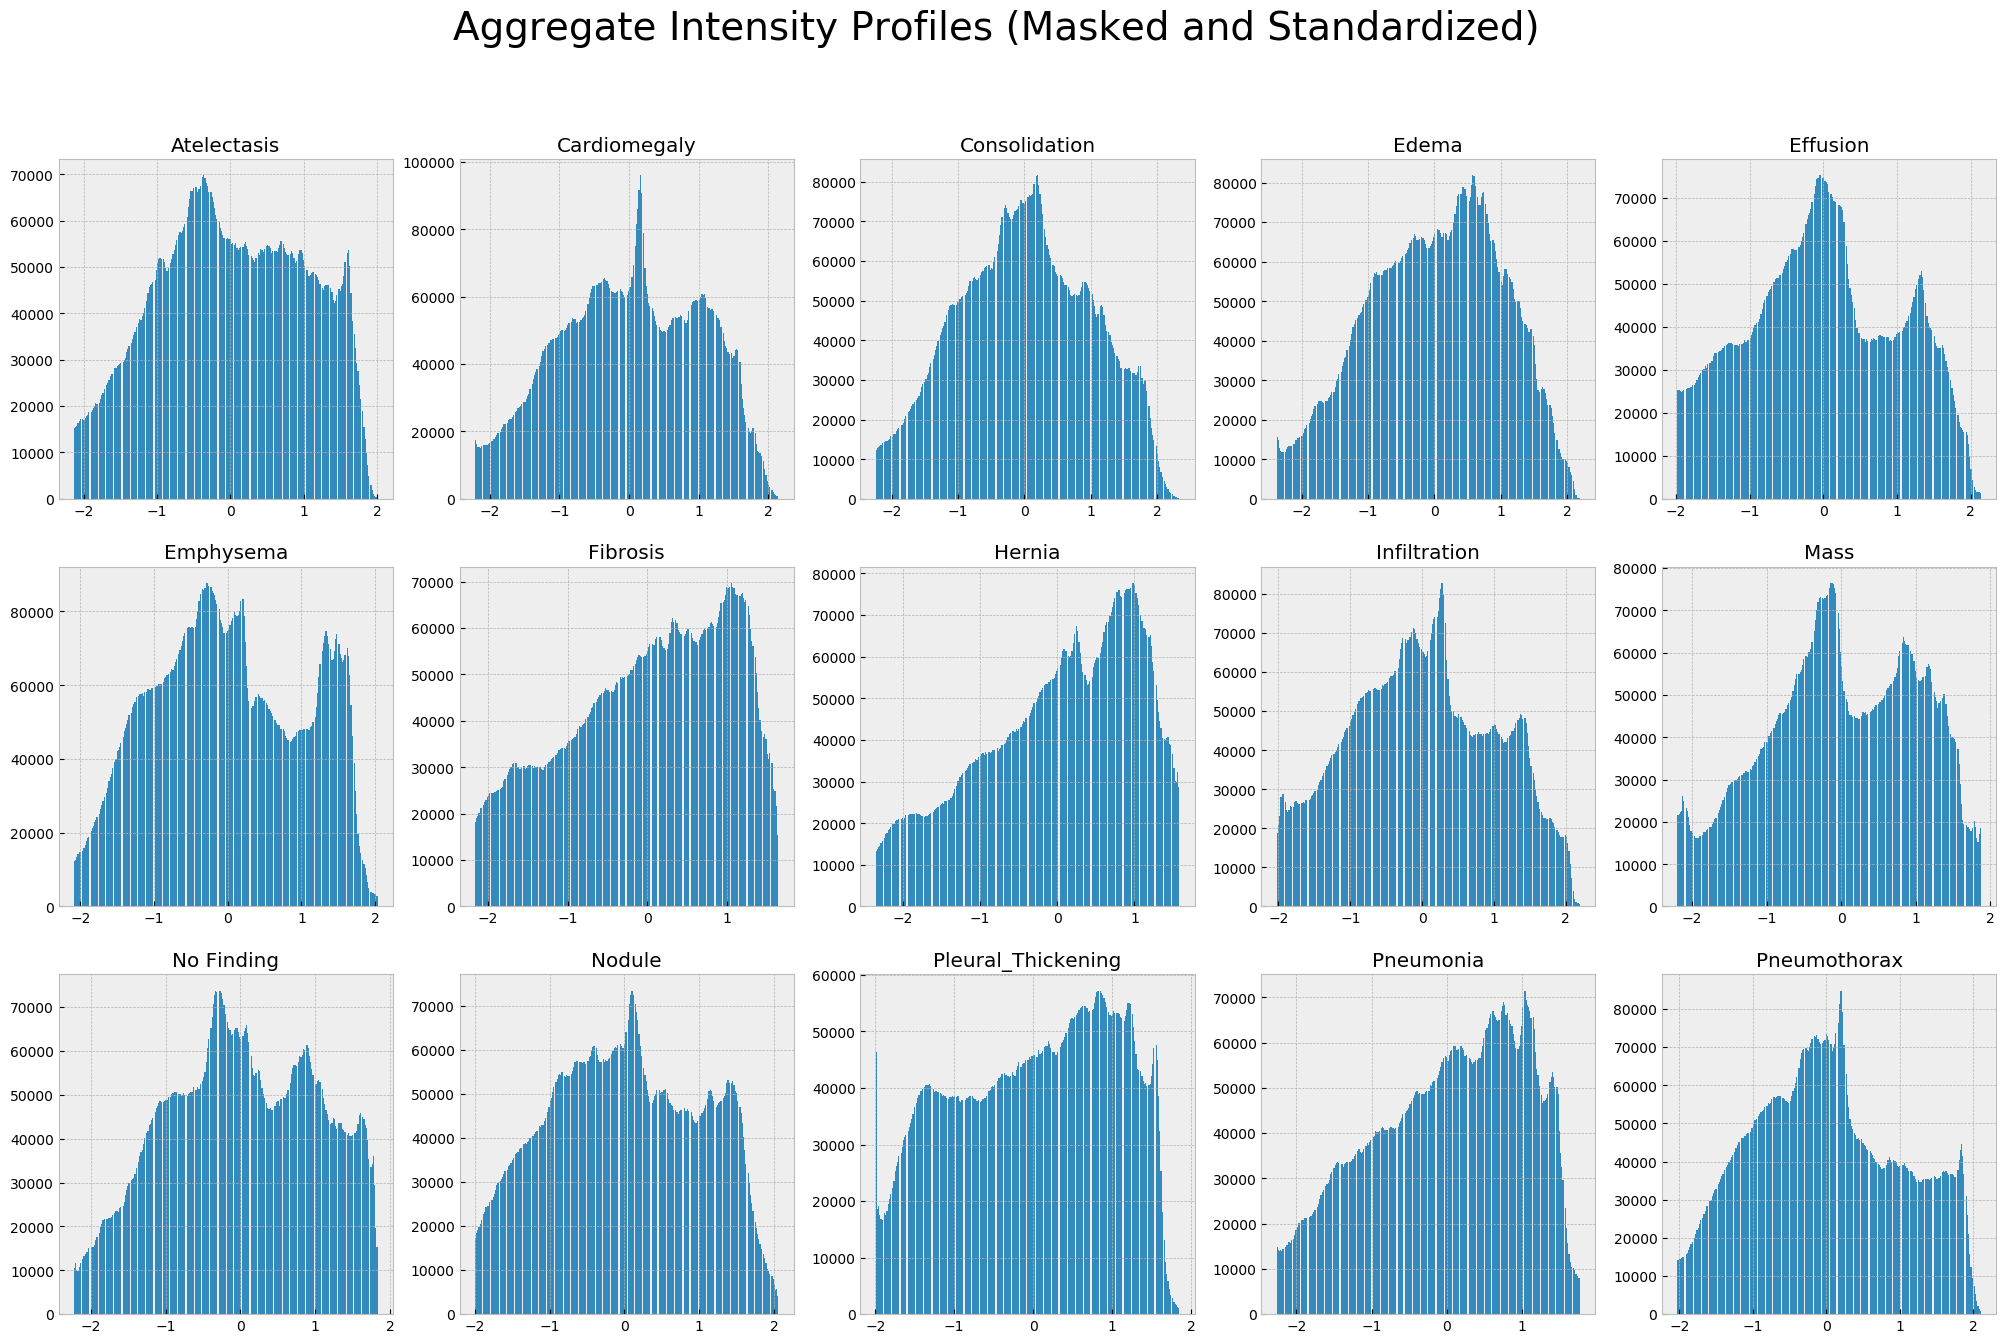

In [126]:
fig=plt.figure(figsize=(25, 15))
fig.tight_layout()
plt.style.use('bmh')
cols = 5
rows = 3
# drop range # as no case where 'No Finding' has a multi-label incidence
for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.hist(standardize(agg_intensities[labels[i-1]]), bins = 256)
    plt.title(labels[i-1])
plt.suptitle('Aggregate Intensity Profiles (Masked and Standardized)', fontsize='28')
plt.show()

In [112]:
mode_intensities = {}
for i,label in enumerate(labels):
    mode_intensities[label] = scipy.stats.mode(agg_intensities[label])[0][0]
mode_intensities

{'Atelectasis': 119,
 'Cardiomegaly': 145,
 'Consolidation': 142,
 'Edema': 167,
 'Effusion': 129,
 'Emphysema': 121,
 'Fibrosis': 210,
 'Hernia': 211,
 'Infiltration': 145,
 'Mass': 136,
 'No Finding': 130,
 'Nodule': 139,
 'Pleural_Thickening': 187,
 'Pneumonia': 204,
 'Pneumothorax': 144}

In [113]:
image_ds = pd.DataFrame({'Label': list(mode_intensities.keys()),
                         'Intensity Mode':  list(mode_intensities.values())})
image_ds.sort_values('Intensity Mode')

Label  Intensity Mode
0          Atelectasis             119
5            Emphysema             121
4             Effusion             129
10          No Finding             130
9                 Mass             136
11              Nodule             139
2        Consolidation             142
14        Pneumothorax             144
1         Cardiomegaly             145
8         Infiltration             145
3                Edema             167
12  Pleural_Thickening             187
13           Pneumonia             204
6             Fibrosis             210
7               Hernia             211

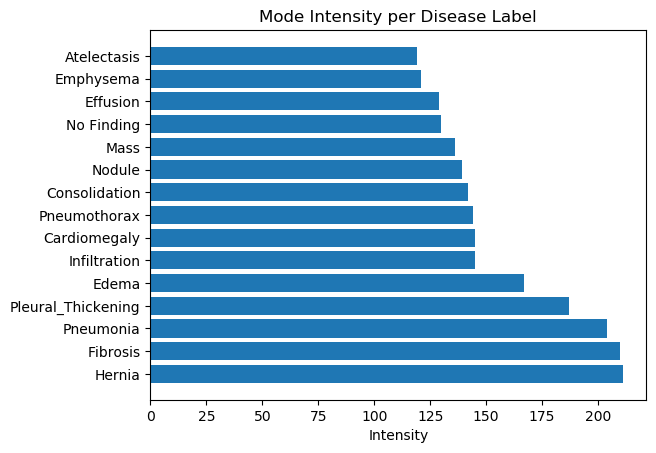

In [114]:
plt.rcdefaults()
fig, ax = plt.subplots()

image_ds = image_ds.sort_values('Intensity Mode')
ax.barh(image_ds['Label'], image_ds['Intensity Mode'],align='center')
ax.set_yticks(image_ds['Label'])
ax.set_yticklabels(image_ds['Label'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Intensity')
ax.set_title('Mode Intensity per Disease Label')

plt.show()

### Conclusions

1.  Dataset is relatively clean, however, there is erroneous 'Patient Age' data which should be cleaned.
2.  We have 30,805 patients in our dataset, an average of about 3-4 images per patient.  Actually, most patients have 0 or 1 follow-ups but may have many more.  We should take the trouble to split the train/test datasets such that patients are either in the train or test dataset, but not both, to prevent data leakage based on any patient having multiple images.
3.  Regarding 'Patient Gender' and 'View Position', the data set has overrepresented 'male' vs 'female' (56%/44%) categories as well as 'PA' vs 'AP' (60%/40%) categories.  The imbalance is relatively moderate and we will randomly sample for the datasets.
4.  Regarding 'Findings', most of the samples are normal, with about half showing 'No Findings'.  Pneumonia which we are looking to predict is present in only ~1.28% of the images.  So we will be dealing with a very small dataset.  We will need to perform data augmentation to help with regularization to prevent overfitting.  We will need to balance the train/test set for positive cases of Pneumonia.  We will split the positive cases between the train/test set (80%/20%).  We will then add enough negative cases for a 50/50 ratio in the train set and 20/80 ratio in the test set.
5.  In looking at the Pneumonia set vs. the non-Pneumonia set, we don't see too much of a difference regarding 'Patient Age' distribution.  Regarding 'Patient Gender', 'Patient Position', and 'Follow-up #', The Pneumonia set has disproporitionately more males, AP position, and follow-ups, but nothing appearing too remarkable.  More noticeable is that those with Pneumonia have a likelihood to have more comorbidities that those labeled with other diseases.  Of co-occurences, Pneumonia shows the strongest co-occurence with Edema and Infiltration.
6.  We investigated the pixel intensity distribution to try and parse out differences within and across diagnoses.  Within the Pneumonia class, the intensity profile presents quite differently depending on comorbidities.  By aggregating the intensity profile for a group of patients all bearing the same disease label, we attempt to glean an pattern distinctive per disease.  It is hard to eyeball, but we can get some idea of distinguishing intensity by masking extremes, standardizing, and taking the mode.  Pneumonia lies close to Pleural_Thickening, Fibrosis, and Hernia in mode and in the correlation matrix it is associated with Edema and Infiltration (which are next closest in mode). We will look out for differences in evaluation metrics for performance or lack of performance with this in mind.  Edema and Infiltration may be most confounding.